In [1]:
# Import required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler, OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, recall_score, precision_score, f1_score

# Hide warnings in the notebook
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# Import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
# Set plots properties
sns.set_style('white')

In [4]:
# Dataset url
file_url = 'https://raw.githubusercontent.com/faadeola/credit-risk-ml-prediction/refs/heads/main/credit_risk_dataset.csv'

# Read dataset for analysis
credit = pd.read_csv(file_url)

# Actual column names
feature_desc_mapping = {
    'person_age' : 'Age',
    'person_income' : 'Annual Income',
    'person_home_ownership' : 'Home Ownership',
    'person_emp_length' : 'Employment Length (in years)',
    'loan_intent' : 'Loan Intent',
    'loan_grade' : 'Loan Grade',
    'loan_amnt' : 'Loan Amount',
    'loan_int_rate' : 'Interest Rate (%)',
    'loan_status' : 'Loan Status',
    'loan_percent_income' : 'Percent Income',
    'cb_person_default_on_file' : 'Historical Default',
    'cb_person_cred_hist_length' : 'Credit History Length'
    }

In [5]:
#vShow 10 random rows in the dataset
credit.sample(frac=0.15)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
11955,22,26000,RENT,5.0,PERSONAL,D,11200,16.89,1,0.43,N,3
7425,24,53000,MORTGAGE,4.0,VENTURE,A,15000,NaN,0,0.28,N,2
20999,33,25000,RENT,NaN,DEBTCONSOLIDATION,C,8500,13.43,1,0.34,N,6
24289,29,71000,MORTGAGE,4.0,HOMEIMPROVEMENT,C,11000,13.43,0,0.15,Y,6
22382,30,55000,MORTGAGE,2.0,EDUCATION,A,11500,7.90,0,0.21,N,9
...,...,...,...,...,...,...,...,...,...,...,...,...
1347,22,29000,RENT,4.0,VENTURE,A,1000,7.29,0,0.03,N,4
2195,26,100000,RENT,0.0,PERSONAL,A,13500,7.14,0,0.14,N,3
16806,24,50000,MORTGAGE,8.0,DEBTCONSOLIDATION,C,3000,13.47,0,0.06,N,3
25264,32,64600,MORTGAGE,12.0,MEDICAL,B,25000,11.36,1,0.33,N,5


# Exploratory Data Analysis and Feature Engineering
This section explores the data file further to understand the structure and distribution

In [6]:
# Shape of the dataset
print(f'Data has {credit.shape[0]} rows and {credit.shape[1]} columns')

Data has 32581 rows and 12 columns


In [7]:
# General overview of the dataset
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [8]:
# Display statistical information about the numerical columns
credit.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.73,6.35,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.85,61983.12,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.79,4.14,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.37,6322.09,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.01,3.24,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.22,0.41,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.17,0.11,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.80,4.06,2.00,3.00,4.00,8.00,30.00


In [9]:
# Check for duplicates in data
has_duplicates = credit.duplicated().sum()

print(f'{has_duplicates} duplicates found in the data')

# Drop duplicates if any
credit.drop_duplicates(keep='first', ignore_index=True, inplace=True)

165 duplicates found in the data


In [10]:
""" Group numerical and categorical data type"""
numerical_columns = credit.select_dtypes(include=['int64','float64']).drop(columns='loan_status') #For numerical data types
categorical_columns = credit.select_dtypes(include='object') #For categorical data types

In [11]:
# Get all unique values for categorical columns
for column in categorical_columns:
  print(f'{column}: {credit[column].unique()}')

person_home_ownership: ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent: ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
loan_grade: ['D' 'B' 'C' 'A' 'E' 'F' 'G']
cb_person_default_on_file: ['Y' 'N']


In [12]:
# Checks for null values
credit.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,887
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,3095
loan_status,0
loan_percent_income,0


In [13]:
""" Fill missing values in the order of Mode (categorical data) and Mean (Numerical data) """

#Fill categorical data
for column in categorical_columns:
    if credit[column].isnull().sum() > 0:
        credit[column] = credit[column].fillna(credit[column].mode())

# Fill numerical data
for column in numerical_columns:
    if credit[column].isnull().sum() > 0:
        credit[column] = credit[column].fillna(credit[column].mean())

In [14]:
# Check if null value still exists
credit.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_status,0
loan_percent_income,0


In [15]:
credit['loan_intent'] = credit['loan_intent'].str.replace('DEBTCONSOLIDATION','Debt Consolidation').str.replace('HOMEIMPROVEMENT','Home Improvement')
credit['loan_intent'].value_counts()

,count
loan_intent,
EDUCATION,6411
MEDICAL,6042
VENTURE,5682
PERSONAL,5498
Debt Consolidation,5189
Home Improvement,3594


In [16]:
# Standardized values in the object columns to title case
for column in categorical_columns:
    credit[column] = credit[column].str.strip().str.title()

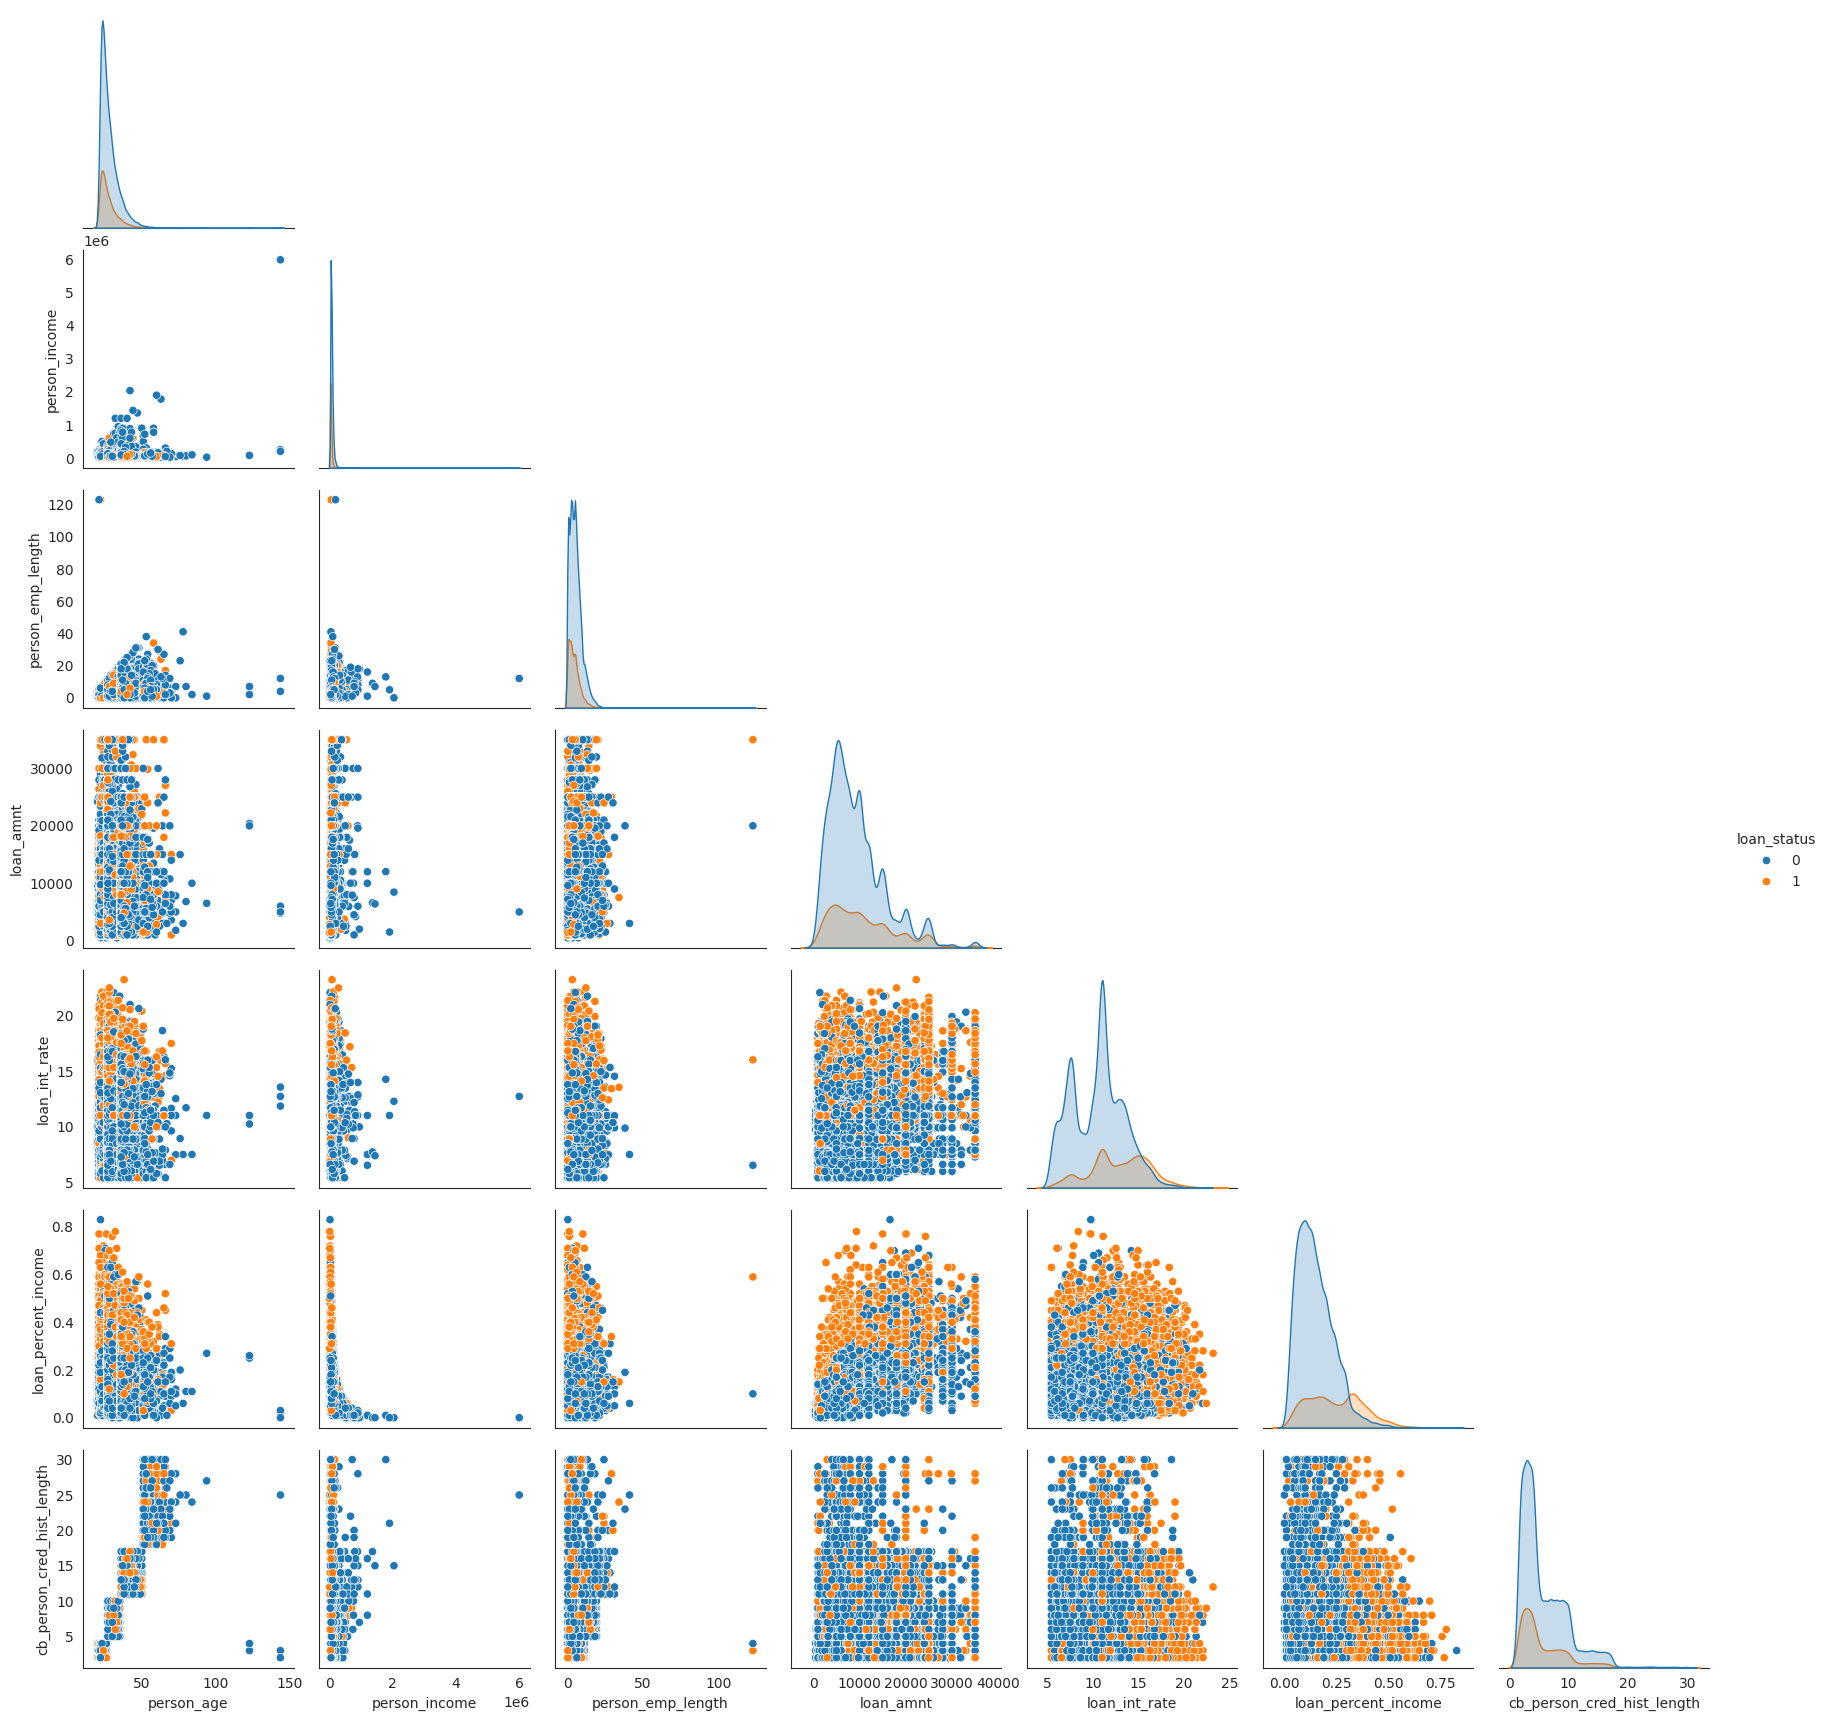

In [17]:
sns.pairplot(credit,hue='loan_status', corner=True)
plt.savefig(f'Pairplot diagram.png', dpi=300)
plt.show()

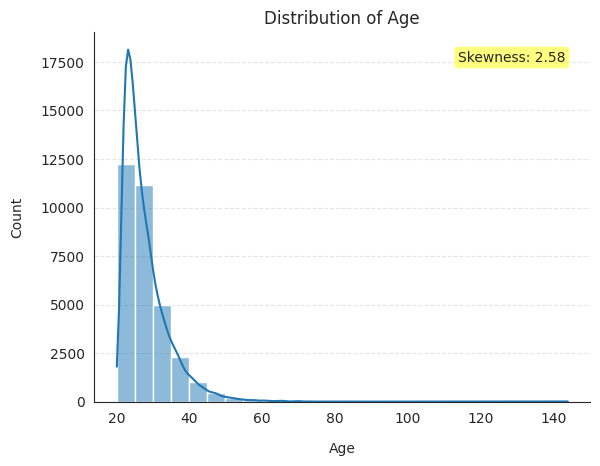

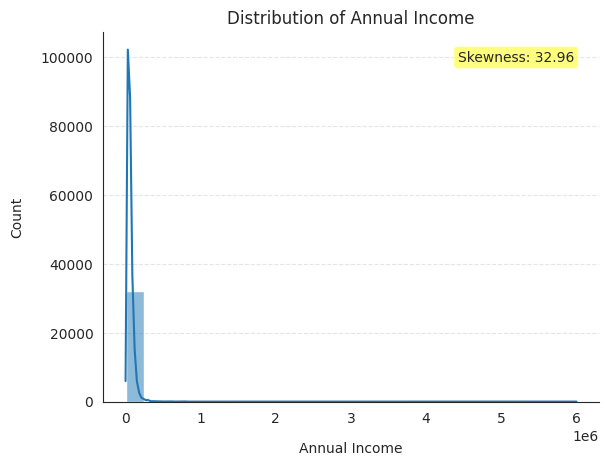

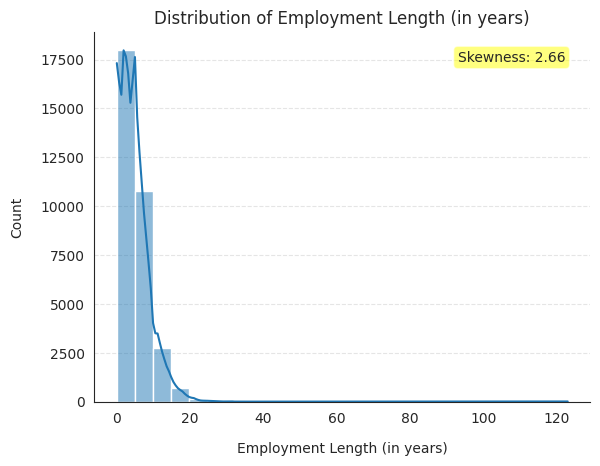

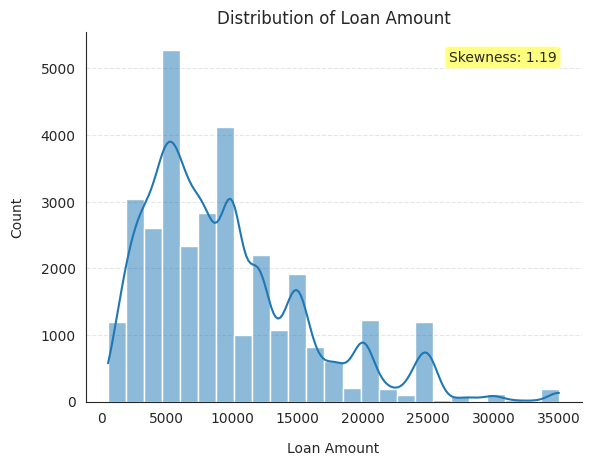

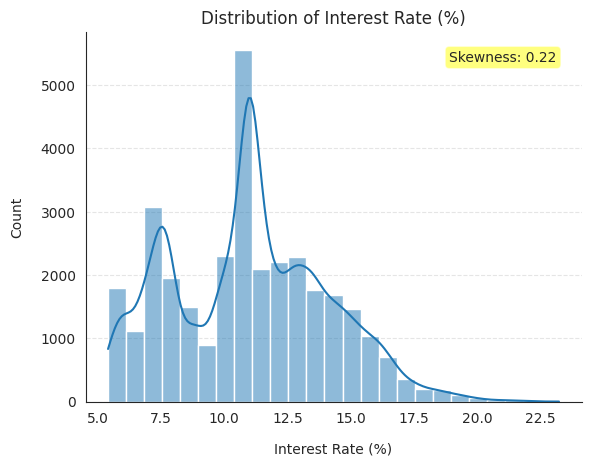

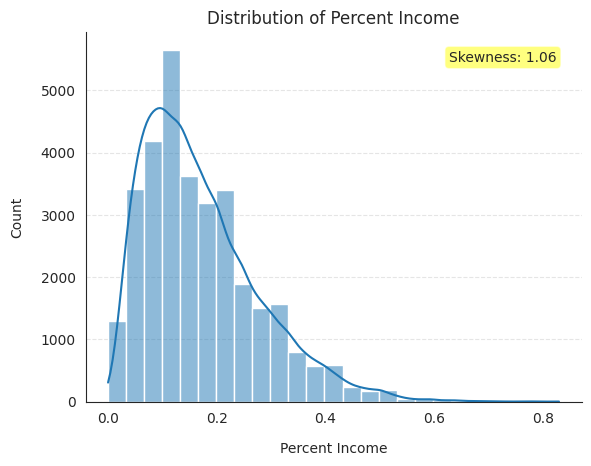

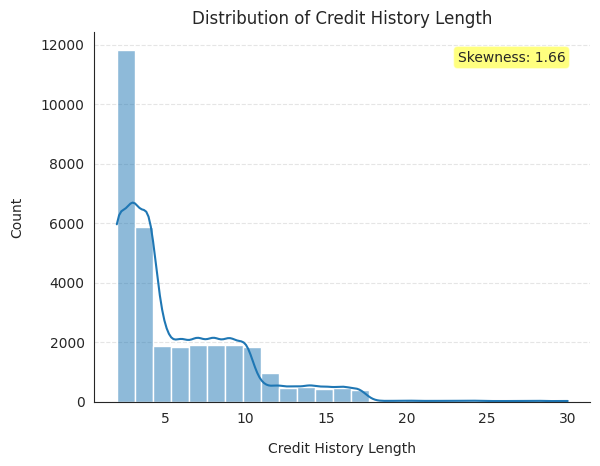

In [18]:
# Plot histogram of the numerical columns in the dataset to understand data distributions
for col in numerical_columns:
  fig, ax = plt.subplots()
  sns.histplot(credit[col],kde=True, bins=25)
  plt.title(f'Distribution of {feature_desc_mapping[col]}')
  plt.text(0.95,0.95,f'Skewness: {credit[col].skew():.2f}', transform = ax.transAxes, horizontalalignment = 'right', verticalalignment = 'top', bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))
  plt.xlabel(f'{feature_desc_mapping[col]}', labelpad=12)
  plt.ylabel('Count', labelpad=12)
  sns.despine(top=True, right=True)
  plt.grid(axis='y',linestyle='--', alpha=0.5)
  plt.savefig(f'Distribution of {feature_desc_mapping[col]}.png', dpi=300)
  plt.show()

  # Print line break after each plot
  print('\n')

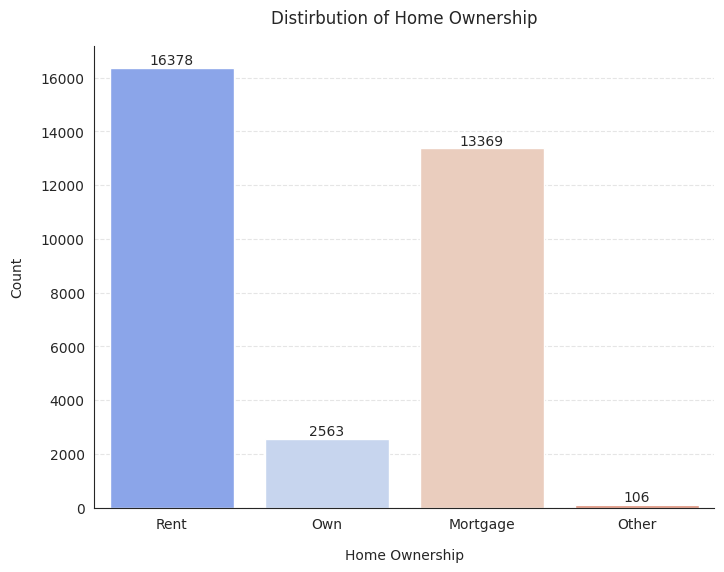

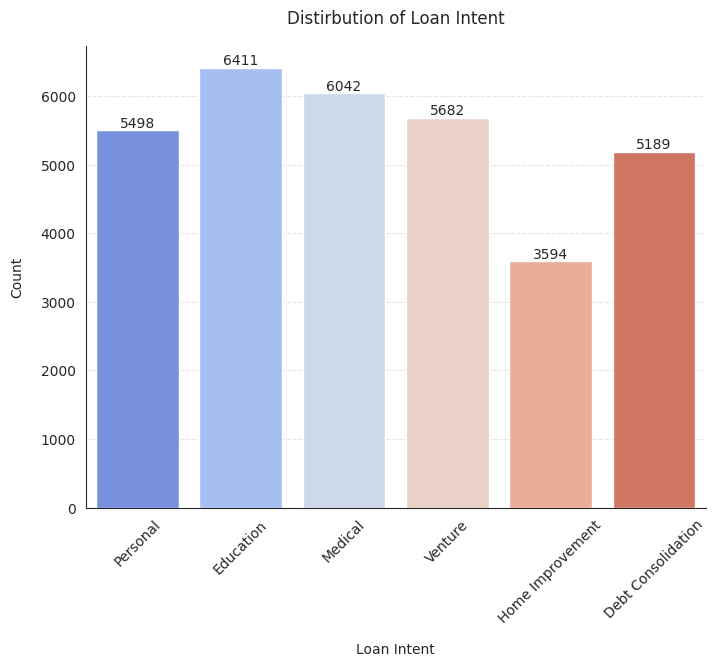

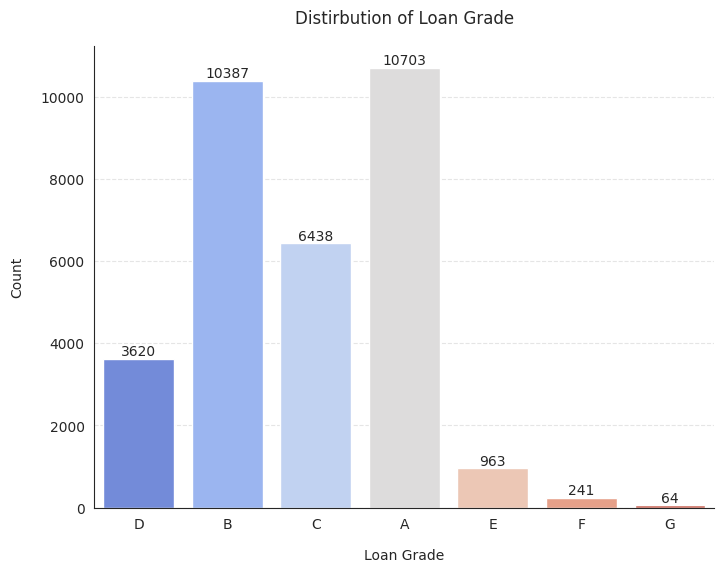

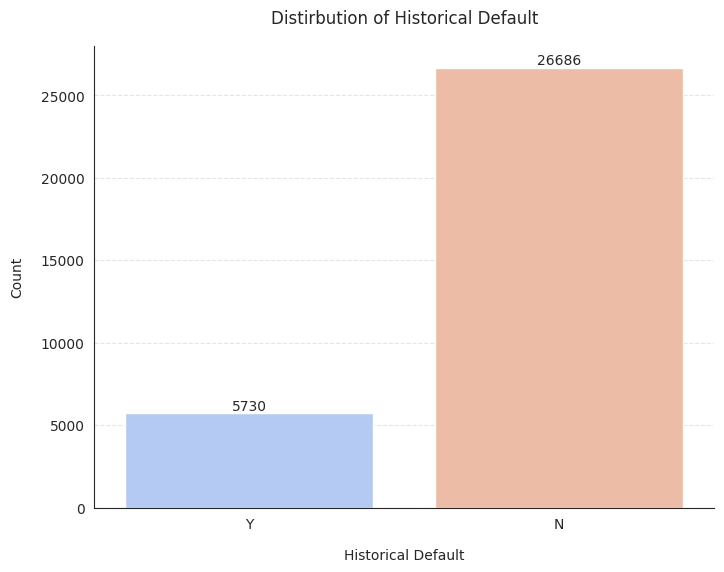

In [19]:
# Display count plot to understand distribution of categorical data
for col in categorical_columns.columns:
  fig,ax = plt.subplots(figsize=(8,6), dpi=100)
  sns.countplot(data=credit, x= f'{col}', palette='coolwarm', ax=ax)
  plt.title(f'Distirbution of {feature_desc_mapping[col]}', pad=16)
  plt.xlabel(f'{feature_desc_mapping[col]}', labelpad=12)

  if col == 'loan_intent':
    plt.xticks(rotation=45)

  plt.ylabel('Count', labelpad=12)

  # Add count labels on top of each bar
  for container in ax.containers:
      ax.bar_label(container, fmt='%d', label_type='edge')

  plt.savefig(f'Distribution of {feature_desc_mapping[col]}.png', dpi=300)
  sns.despine(top=True, right=True)
  plt.grid(axis='y',linestyle='--', alpha=0.5)
  plt.show()

  # Print line break after each plot
  print('\n')

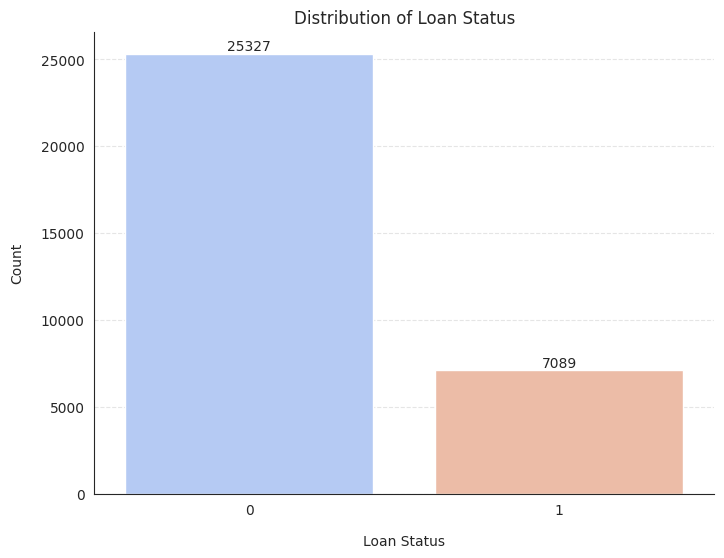

In [20]:
# Distribution of target feature
fig,ax= plt.subplots(figsize=(8,6), dpi=100)
sns.countplot(data=credit, x='loan_status', palette='coolwarm', ax=ax)

# Add count labels on top of each bar
for container in ax.containers:
  ax.bar_label(container, fmt='%d', label_type='edge')
plt.title('Distribution of Loan Status')
plt.xlabel('Loan Status', labelpad=12)
plt.ylabel('Count', labelpad=12)
sns.despine(top=True, right=True)
plt.grid(axis='y',linestyle='--', alpha=0.5)
plt.savefig(f'Distribution of Loan Status.png', dpi=300)
plt.show()

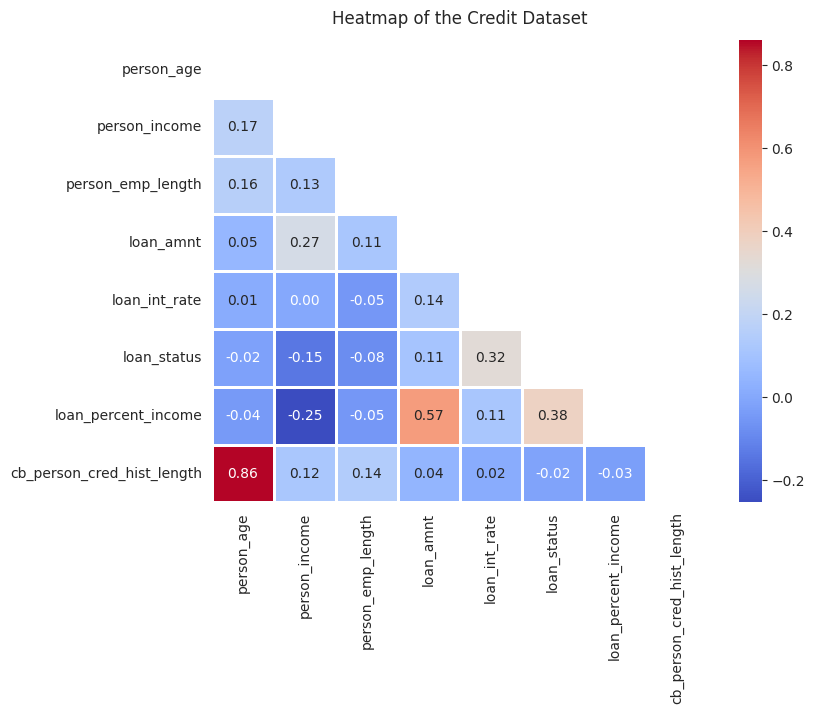

In [21]:
# Heat map of credit data
credit_corr = credit.corr(numeric_only=True)
mask = np.triu(np.ones_like(credit_corr))
plt.subplots(figsize=(8,6))
sns.heatmap(data=credit_corr, mask=mask, fmt='.2f', annot=True, cmap='coolwarm', linewidths=2, cbar=True)
plt.title('Heatmap of the Credit Dataset', pad=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('Heatmap of the Credit Dataset')
plt.show()


In [22]:
"""Classify person into age groups"""
# categorize age into groups
bin = [20,30,40,50,60,120]
age_label = ['20-30','31-40','41-50','51-60','60 and above']

# create group and add to daataset as a new column
credit['age group'] = pd.cut(credit['person_age'],bins=bin, labels=age_label, right=True, include_lowest=True)

In [23]:
"""Classify income into groups"""
# categorize age into groups
bin = [0,500000,2000000,999999999]
income_label = ['Low','Moderate','High']

# create group and add to daataset as a new column
credit['income_bracket'] = pd.cut(credit['person_income'],bins=bin, labels=income_label, right=True, include_lowest=True)

In [24]:
credit['loan_to_income'] = round(credit['loan_amnt'] / credit['person_income'],2)

"""Create new column to understand loan burden on income"""
credit['loan_burden'] = np.where(credit['loan_to_income']>0.6,'High',
                                 np.where(credit['loan_to_income']>0.3,'Moderate','Low'))

In [25]:
# Add newly created columns to feature mapping dictionary
feature_desc_mapping['income_bracket'] = 'Income Bracket'
feature_desc_mapping['loan_to_income'] = 'Loan to Income Ratio'
feature_desc_mapping['loan_burden'] = 'Loan Burden'

In [26]:
# Transform credit history to numerical column
credit['cb_person_default_on_file'] = np.where(credit['cb_person_default_on_file']=='Y',1,0).astype('int')

In [27]:
credit.head(10)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,age group,income_bracket,loan_to_income,loan_burden
0,22,59000,Rent,123.0,Personal,D,35000,16.02,1,0.59,1,3,20-30,Low,0.59,Moderate
1,21,9600,Own,5.0,Education,B,1000,11.14,0,0.10,0,2,20-30,Low,0.10,Low
2,25,9600,Mortgage,1.0,Medical,C,5500,12.87,1,0.57,0,3,20-30,Low,0.57,Moderate
3,23,65500,Rent,4.0,Medical,C,35000,15.23,1,0.53,0,2,20-30,Low,0.53,Moderate
4,24,54400,Rent,8.0,Medical,C,35000,14.27,1,0.55,1,4,20-30,Low,0.64,High
5,21,9900,Own,2.0,Venture,A,2500,7.14,1,0.25,0,2,20-30,Low,0.25,Low
6,26,77100,Rent,8.0,Education,B,35000,12.42,1,0.45,0,3,20-30,Low,0.45,Moderate
7,24,78956,Rent,5.0,Medical,B,35000,11.11,1,0.44,0,4,20-30,Low,0.44,Moderate
8,24,83000,Rent,8.0,Personal,A,35000,8.90,1,0.42,0,2,20-30,Low,0.42,Moderate
9,21,10000,Own,6.0,Venture,D,1600,14.74,1,0.16,0,3,20-30,Low,0.16,Low


In [28]:
# Understand the distribution of low income earner to the loan burden to be incurred due to amount requested

low_inc_high_loan = credit[(credit['income_bracket'] == 'Low') & (credit['loan_burden'] == 'High')].count()[0].astype('int')

low_inc_moderate_loan = credit[(credit['income_bracket'] == 'Low') & (credit['loan_burden'] == 'Moderate')].count()[0].astype('int')

low_inc_low_loan = credit[(credit['income_bracket'] == 'Low') & (credit['loan_burden'] == 'Low')].count()[0].astype('int')

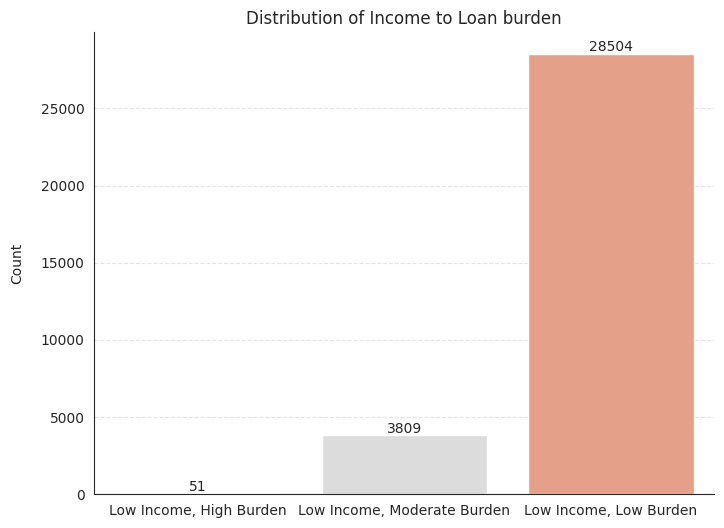

In [29]:
# plot graph of person income to loan burden
inc_to_burden = pd.DataFrame({
  'index_value': ['Low Income, High Burden','Low Income, Moderate Burden','Low Income, Low Burden'],
  'count': [low_inc_high_loan,low_inc_moderate_loan,low_inc_low_loan]
})

# display visualization
fig,ax= plt.subplots(figsize=(8,6), dpi=100)
sns.barplot(data=inc_to_burden, x='index_value', y='count', palette='coolwarm')

# Add count labels on top of each bar
for container in ax.containers:
  ax.bar_label(container, fmt='%d', label_type='edge')
plt.title('Distribution of Income to Loan burden')
plt.xlabel('', labelpad=16, fontsize=14)
plt.ylabel('Count', labelpad=12)
sns.despine(top=True, right=True)
plt.grid(axis='y',linestyle='--', alpha=0.5)
plt.savefig(f'Distribution of Income to Loan burden.png', dpi=300)
plt.show()

In [30]:
''' Check for outliers in the data'''

def get_outlier(column):
    # This function returns the outliers in a column

    Q1 = credit[column].quantile(0.25)
    Q3 = credit[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - (1.5 * IQR) #--Get the lower bound values
    upper_bound = Q3 + (1.5 * IQR) #--Get the upper bound values

    outliers = ((credit[column] < lower_bound) | (credit[column] > upper_bound))

    return outliers, outliers.sum()

# Dictionary to hold outliers in each columns
outlier_dict = {}

# Get the number of outliers in each column
for col in numerical_columns.columns:
    col_outlier = get_outlier(col)[1] # Stores number of outlier in a column
    outlier_dict[col] = col_outlier # Add value and key to dictionary

# Display dictionary information as a DataFrame
outlier_df = pd.DataFrame({'Outlier Count': outlier_dict})
outlier_df.head()

,Outlier Count
person_age,1491
person_income,1478
person_emp_length,852
loan_amnt,1679
loan_int_rate,70


In [31]:
# Remove outliers across all numerical columns
def remove_outliers(numerical_cols):
    """
    Removes rows where numerical columns has an outlier.
    """
    row_mask = pd.Series(True, index=credit.index)

    for col in numerical_cols:
        col_outliers = get_outlier(col)[0]
        row_mask = row_mask & (~col_outliers)

    return credit[row_mask].copy()

# Assign clean data to initial dataframe name
credit = remove_outliers(numerical_columns)

In [32]:
# Check the new shape of the data
print(f'The dataframe now have {credit.shape[0]} rows and {credit.shape[1]} columns after removing outliers')

The dataframe now have 26833 rows and 16 columns after removing outliers


In [33]:
""" Group numerical and categorical data type"""
numerical_columns = credit.select_dtypes(include=['int64','float64']).drop(columns='loan_status') #For numerical data types
categorical_columns = credit.select_dtypes(include='object') #For categorical data types

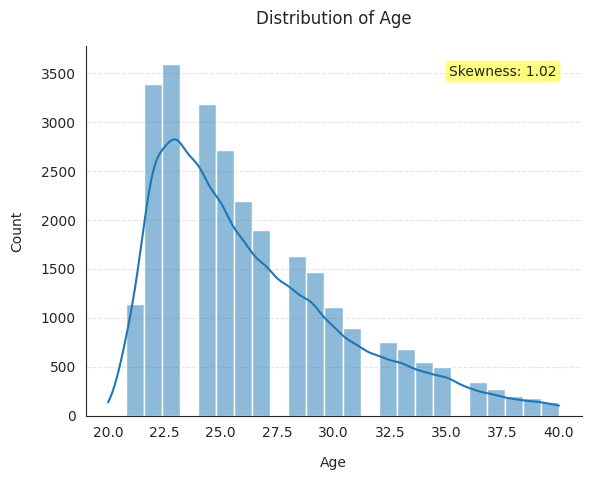

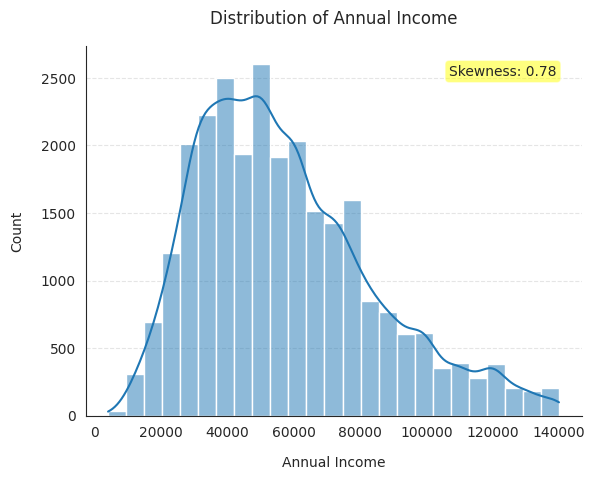

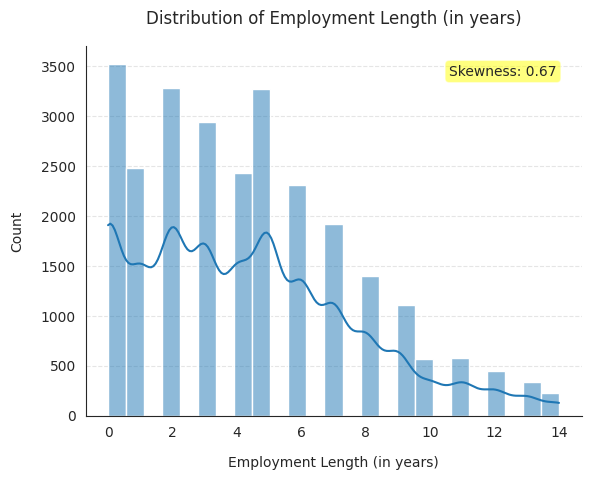

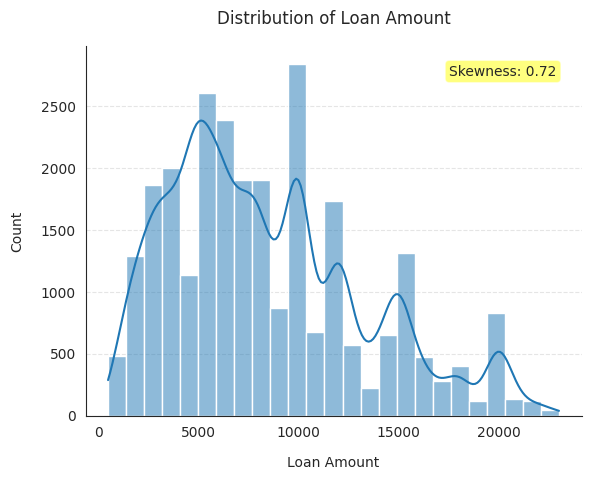

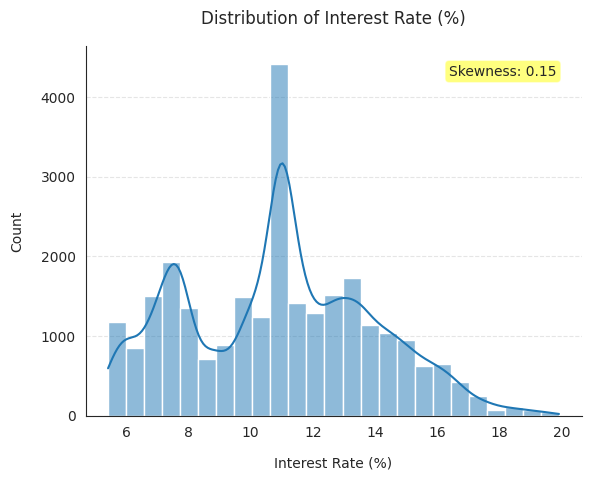

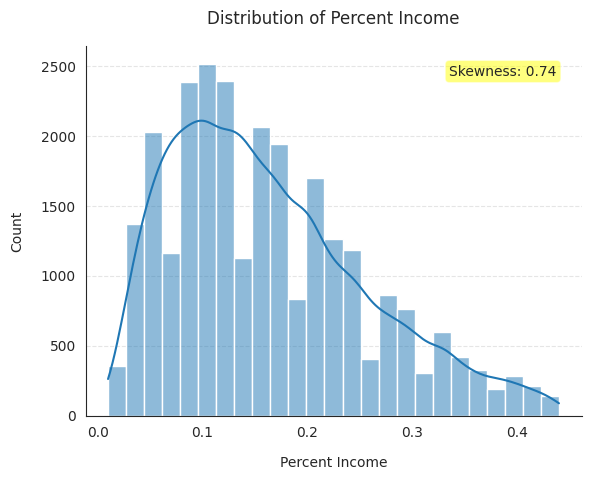

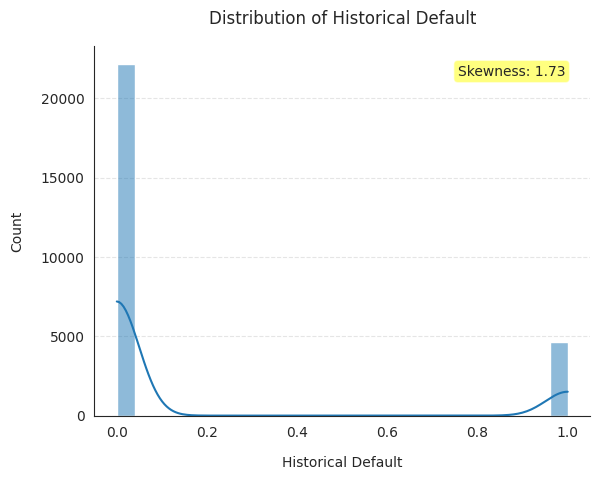

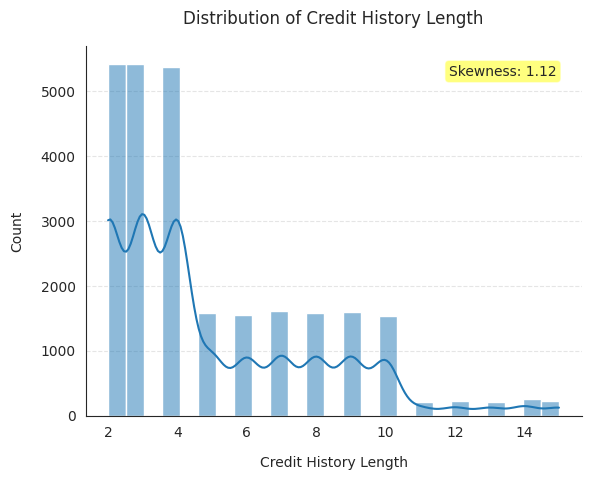

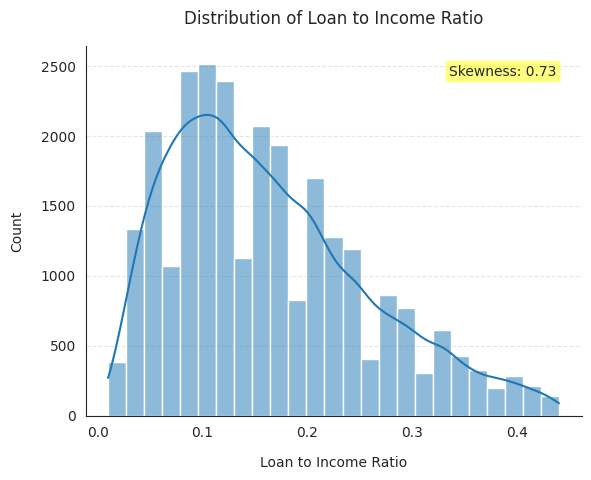

In [34]:
""" Plot histogram after removing outliers to understand new distribution """

for col in numerical_columns:
  fig, ax = plt.subplots()
  sns.histplot(credit[col],kde=True, bins=25)
  plt.title(f'Distribution of {feature_desc_mapping[col]}', pad=16)

  plt.text(0.95,0.95,f'Skewness: {credit[col].skew():.2f}', transform = ax.transAxes, horizontalalignment = 'right', verticalalignment = 'top', bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

  plt.xlabel(f'{feature_desc_mapping[col]}', labelpad=12)
  plt.ylabel('Count', labelpad=12)
  sns.despine(top=True, right=True)
  plt.grid(axis='y',linestyle='--', alpha=0.5)
  plt.savefig(f'Distribution of {feature_desc_mapping[col]} after removing outliers.png', dpi=300)
  plt.show()

  # Print line break after each plot
  print('\n')

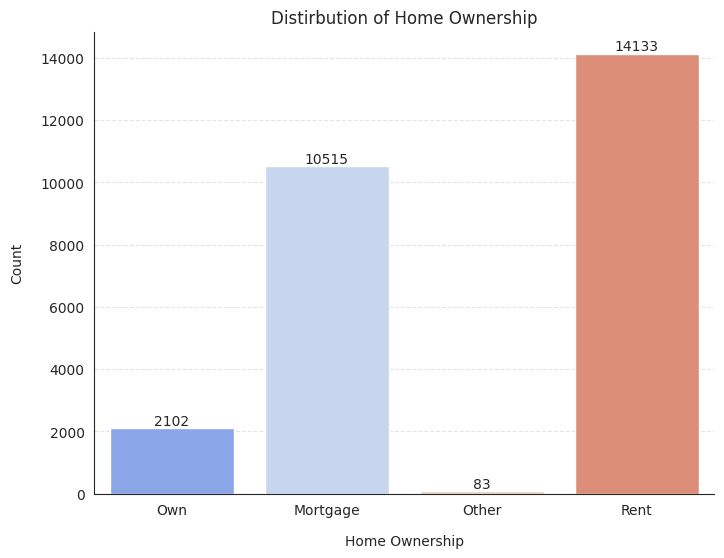

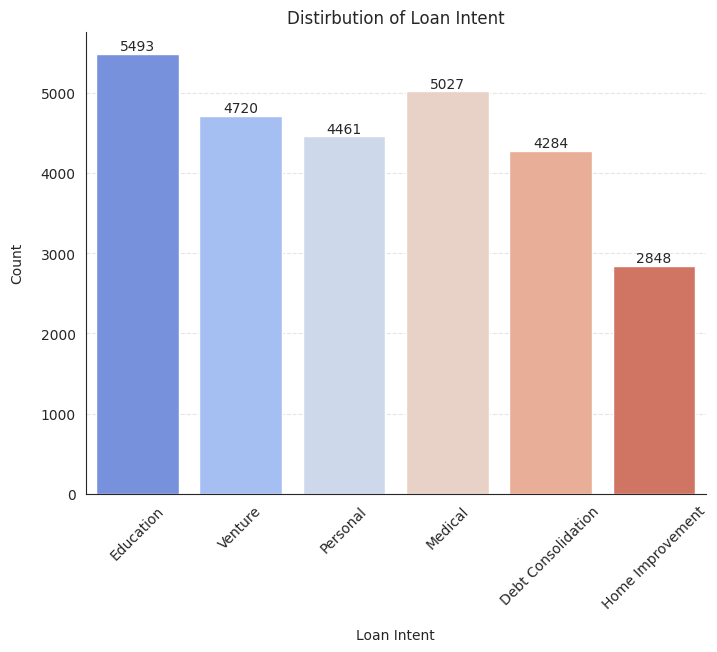

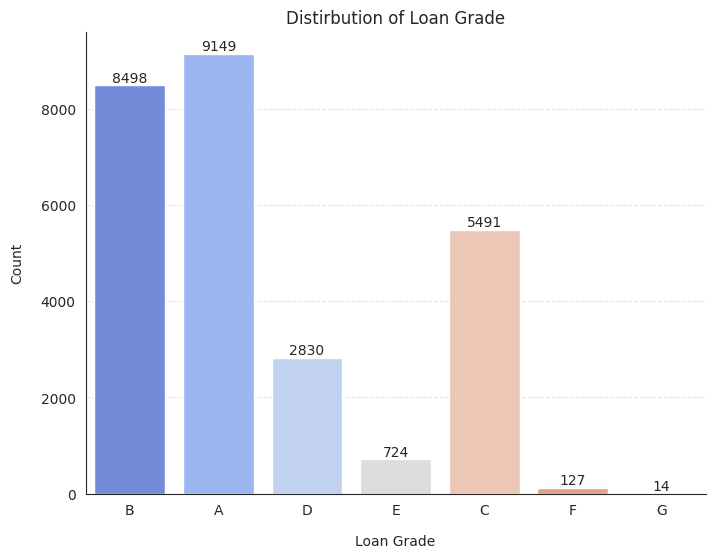

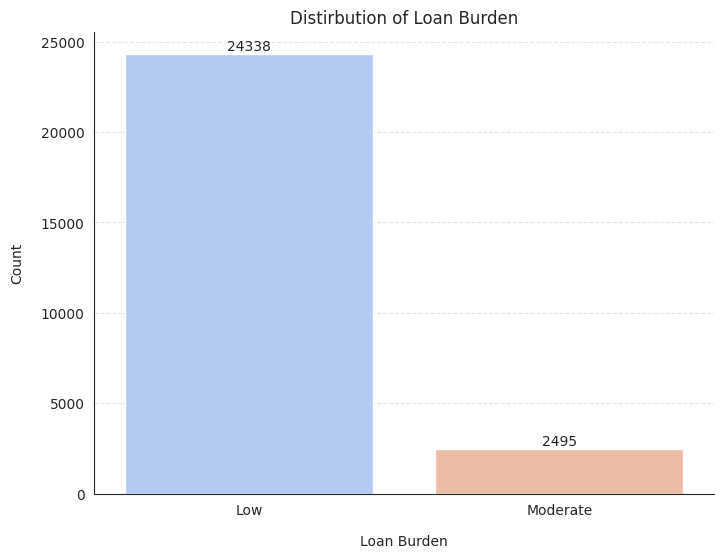

In [35]:
# Display count plot to understand distribution of categorical data after removing outliers
for col in categorical_columns.columns:
  fig,ax = plt.subplots(figsize=(8,6), dpi=100)
  sns.countplot(data=credit, x= f'{col}', palette='coolwarm', ax=ax)
  plt.title(f'Distirbution of {feature_desc_mapping[col]}')
  plt.xlabel(f'{feature_desc_mapping[col]}', labelpad=12)

  if col == 'loan_intent':
    plt.xticks(rotation=45)

  plt.ylabel('Count', labelpad=12)

  # Add count labels on top of each bar
  for container in ax.containers:
      ax.bar_label(container, fmt='%d', label_type='edge')

  plt.savefig(f'Distribution of {feature_desc_mapping[col]} after removing outliers.png', dpi=300)
  sns.despine(top=True, right=True)
  plt.grid(axis='y',linestyle='--', alpha=0.5)
  plt.show()

  # Print line break after each plot
  print('\n')

# Data Preprocessing
Preparation for model training

In [36]:
# Split data into feature and target
feature = credit.drop(columns=['person_age','loan_status'])
target = credit['loan_status']

In [37]:
"""Group data types"""

# Numerical columns
feature_num_columns = feature.select_dtypes(include=['int','float']).columns

# Ordinal columns
feature_ord_columns = feature[['loan_grade']].columns

# Ordinal columns
level_columns = feature[['loan_burden','income_bracket']].columns

# Catgorical columns
feature_cat_columns = feature.select_dtypes(include=['object','category']).drop(columns='loan_grade',axis=1).columns

In [38]:
""" This section splits the dataset into training, validation and testing"""

# Split columns for training and testing
X_train, x_test, Y_train, y_test = train_test_split(feature, target, test_size = 0.001, random_state = 42)

# Further split of the training data for validation and main training
X_Main_train, x_valid, Y_Main_train, y_valid = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 42)

In [39]:
# Get shape of split data
print(f'X_Main_train has {X_Main_train.shape[0]} rows for training')
print(f'Y_Main_train has {Y_Main_train.shape[0]} rows for training')
print(f'x_valid has {x_valid.shape[0]} rows for validation')
print(f'y_valid has {y_valid.shape[0]} rows for validation')
print(f'x_test has {x_test.shape[0]} rows for testing')
print(f'y_test has {y_test.shape[0]} rows for testing')

X_Main_train has 21444 rows for training
Y_Main_train has 21444 rows for training
x_valid has 5362 rows for validation
y_valid has 5362 rows for validation
x_test has 27 rows for testing
y_test has 27 rows for testing


In [40]:
# Make column transformation
preprocessor = ColumnTransformer([
    ('scaler', RobustScaler(), feature_num_columns),
    ('fencoder', OrdinalEncoder(categories=[['G','F','E','D','C','B','A']]), feature_ord_columns),
    ('lencoder', OrdinalEncoder(categories=[['Low','Moderate','High'],['Low','Moderate','High']]), level_columns),
    ('one-hot', OneHotEncoder(handle_unknown='ignore'), feature_cat_columns)
    ], remainder = 'passthrough'
  )

# Baseline Model training






In [41]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('sampling', SMOTE()),
    ('model', RandomForestClassifier())
])

In [42]:
# Architecture of the pipeline
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', RobustScaler(),
                                                  Index(['person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate',
       'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_to_income'],
      dtype='object')),
                                                 ('fencoder',
                                                  OrdinalEncoder(categories=[['G',
                                                                              'F',
                                                                              'E',...
                                                  OrdinalEncoder(categories=[['Low',
                                                                              'Moderate',
                                                                              'High'],
                                                                             ['Low',
                                                                              'Moderate',
                                                                              'High']]),
                                                  Index(['loan_burden', 'income_bracket'], dtype='object')),
                                                 ('one-hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['person_home_ownership', 'loan_intent', 'age group', 'income_bracket',
       'loan_burden'],
      dtype='object'))])),
                ('sampling', SMOTE()), ('model', RandomForestClassifier())])

In [43]:
""" Multiple dictionaries to store models and model receiver operating characteristics result"""

# Create dictionary to store models
models = {
    'rfc': {
        'name':'Random Forest',
        'model': RandomForestClassifier(random_state=42)
    },
    'dtc': {
        'name': 'Decision Tree',
        'model': DecisionTreeClassifier(random_state=42)
    },
    'xgb': {
        'name': 'XGBoost',
        'model': XGBClassifier(random_state=42)
    },
    'lgrc': {
        'name': 'Logistic Regression',
        'model': LogisticRegression(random_state=42)
    },
    'lgbm': {
        'name': 'LightGBM',
        'model': LGBMClassifier(random_state=42)
    },
    'svm': {
        'name': 'Support Vector Machine',
        'model': SVC(probability=True, kernel='rbf', random_state=42)
    }
}

# Dictionary to store receiver operating characteristics results
roc_results = {}

In [44]:
# Create dictionary and list to store recall, accuracy score, precision and f1-score of each model for visualization

model_name = []
model_accuracy = []
model_recall = []
model_precision = []
model_f1score = []

----------------------------------------------------------------------------------------------------
--> Random Forest <--
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      4295
           1       0.91      0.71      0.79      1067

    accuracy                           0.93      5362
   macro avg       0.92      0.84      0.87      5362
weighted avg       0.93      0.93      0.92      5362



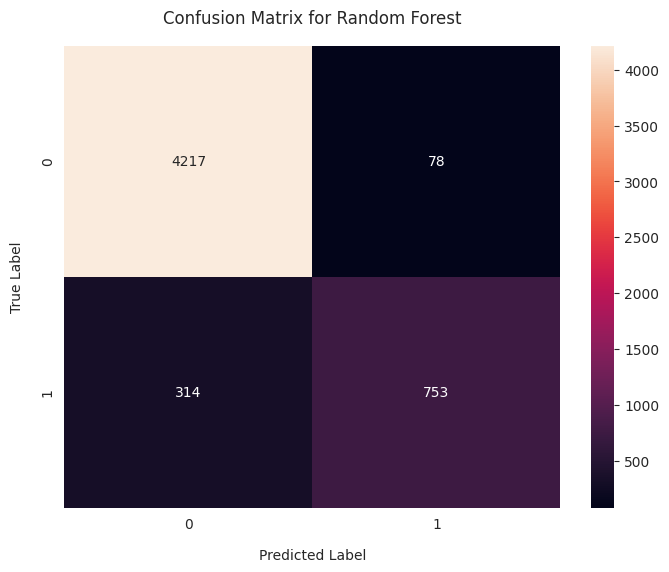




----------------------------------------------------------------------------------------------------
Predictions on test data by Random Forest
----------------------------------------------------------------------------------------------------
    True Label  Predcited Label Correct Predicition
26           1                1                 Yes
11           0                0                 Yes
15           1                1                 Yes
7            0                0                 Yes
2            0                0                 Yes
22           1                0                  No
0            1                1                 Yes
9            0                0                 Yes
6            0                0                 Yes
24           0                0                 Yes




----------------------------------------------------------------------------------------------------
--> Decision Tree <--
------------------------------------------------------

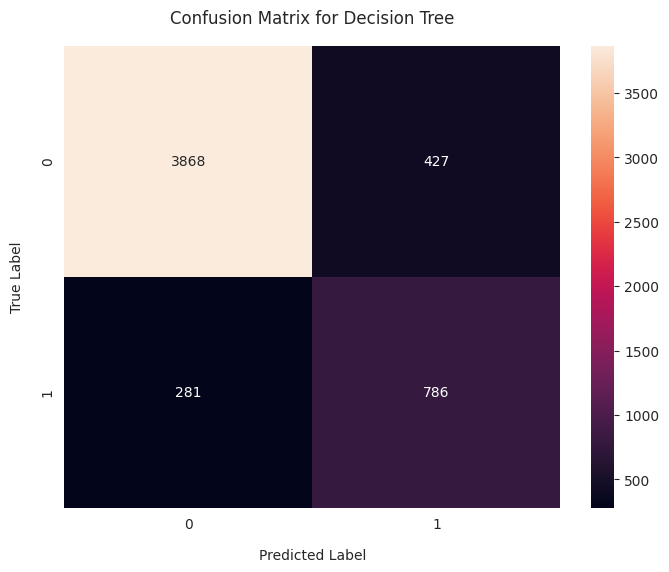




----------------------------------------------------------------------------------------------------
Predictions on test data by Decision Tree
----------------------------------------------------------------------------------------------------
    True Label  Predcited Label Correct Predicition
23           1                0                  No
13           0                0                 Yes
20           0                0                 Yes
9            0                0                 Yes
3            1                0                  No
5            0                0                 Yes
21           0                0                 Yes
7            0                0                 Yes
24           0                0                 Yes
26           1                1                 Yes




----------------------------------------------------------------------------------------------------
--> XGBoost <--
------------------------------------------------------------

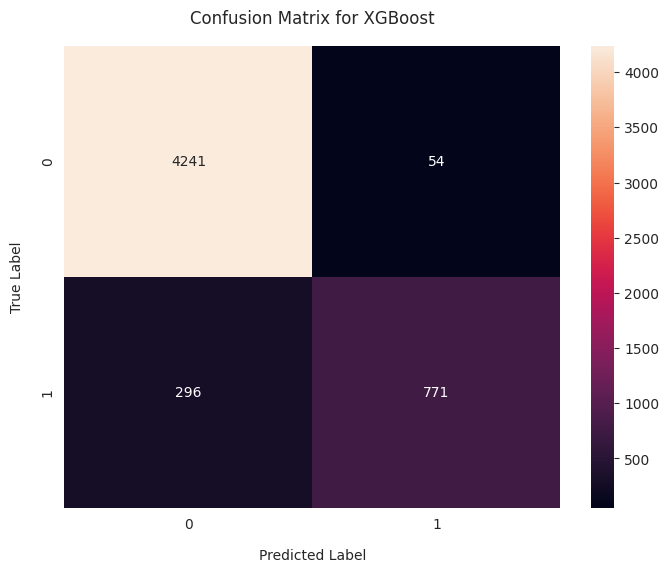




----------------------------------------------------------------------------------------------------
Predictions on test data by XGBoost
----------------------------------------------------------------------------------------------------
    True Label  Predcited Label Correct Predicition
1            0                0                 Yes
3            1                0                  No
17           0                0                 Yes
4            0                0                 Yes
11           0                0                 Yes
14           0                0                 Yes
5            0                0                 Yes
7            0                0                 Yes
0            1                1                 Yes
6            0                0                 Yes




----------------------------------------------------------------------------------------------------
--> Logistic Regression <--
------------------------------------------------------

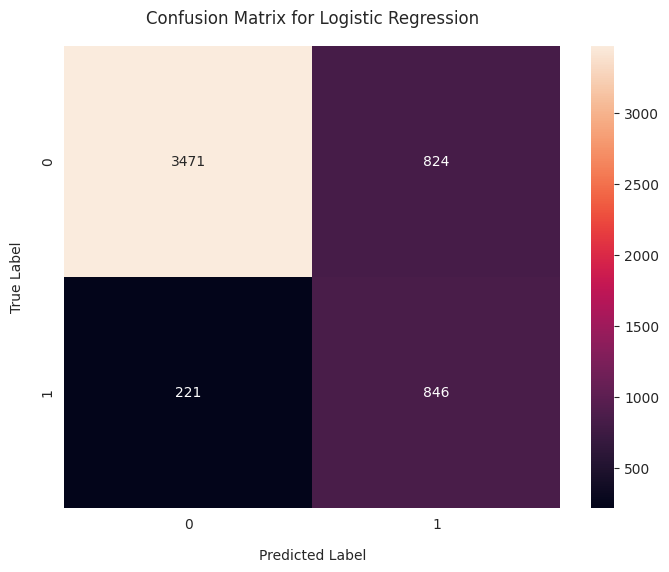




----------------------------------------------------------------------------------------------------
Predictions on test data by Logistic Regression
----------------------------------------------------------------------------------------------------
    True Label  Predcited Label Correct Predicition
21           0                0                 Yes
17           0                0                 Yes
9            0                0                 Yes
12           0                0                 Yes
20           0                0                 Yes
19           0                1                  No
14           0                0                 Yes
18           0                0                 Yes
15           1                1                 Yes
10           1                1                 Yes




[LightGBM] [Info] Number of positive: 16959, number of negative: 16959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008974 secon

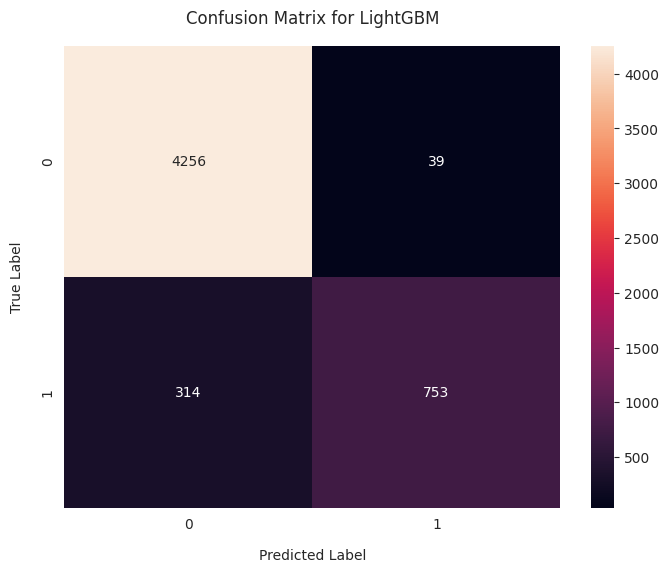




----------------------------------------------------------------------------------------------------
Predictions on test data by LightGBM
----------------------------------------------------------------------------------------------------
    True Label  Predcited Label Correct Predicition
13           0                0                 Yes
26           1                1                 Yes
4            0                0                 Yes
14           0                0                 Yes
12           0                0                 Yes
8            1                1                 Yes
19           0                0                 Yes
5            0                0                 Yes
24           0                0                 Yes
7            0                0                 Yes




----------------------------------------------------------------------------------------------------
--> Support Vector Machine <--
--------------------------------------------------

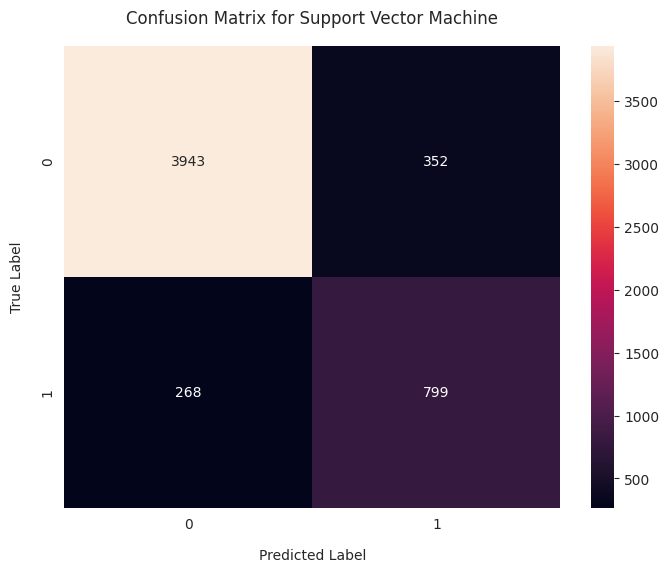




----------------------------------------------------------------------------------------------------
Predictions on test data by Support Vector Machine
----------------------------------------------------------------------------------------------------
    True Label  Predcited Label Correct Predicition
26           1                1                 Yes
9            0                0                 Yes
1            0                0                 Yes
24           0                0                 Yes
19           0                1                  No
6            0                0                 Yes
23           1                1                 Yes
0            1                1                 Yes
4            0                0                 Yes
25           1                1                 Yes






In [45]:
''' Training models by looping through the model dictionary while also outputing metrics'''

for abbr, model_dict in models.items():

  # Chnange the default model in the pipeline to the current running model
  pipeline.set_params(model = model_dict['model'])

  # Train model with split data
  pipeline.fit(X_Main_train,Y_Main_train)

  # Make prediction using
  y_pred = pipeline.predict(x_valid)

  # Get metrics
  class_report = classification_report(y_valid,y_pred)
  cm = confusion_matrix(y_valid,y_pred)

  # Store result of each model metrics for visualization
  model_name.append(model_dict['name'])
  model_accuracy.append(accuracy_score(y_valid,y_pred))
  model_recall.append(recall_score(y_valid,y_pred))
  model_precision.append(precision_score(y_valid,y_pred))
  model_f1score.append(f1_score(y_valid,y_pred))

  # Show metrics
  print('-'*100)
  print(f'--> {model_dict['name']} <--')
  print('-'*100)
  print(class_report)

  # Plot the confusion matrix of the model
  plt.subplots(figsize=(8,6), dpi=100)
  sns.heatmap(cm,annot=True,fmt='d',cbar=True,)
  plt.xlabel('Predicted Label', labelpad=12)
  plt.ylabel('True Label', labelpad=12)
  plt.title(f'Confusion Matrix for {model_dict['name']}', pad=16)
  plt.savefig(f'Confusion Matrix for {model_dict['name']}.png',dpi=300)
  plt.show()

  # Add line break
  print('\n\n')

  """ Make predictions with each model on the test data """
  print('-'*100)
  print(f'Predictions on test data by {model_dict['name']}')
  print('-'*100)

  # Predict on unseen data from x_test
  y_test_pred = pipeline.predict(x_test)

  # Map predictions if they are equal
  correct_predicition = ['Yes' if y_test_pred[i] == y_test.iloc[i] else 'No' for i in range(len(y_test_pred))]

  # Dataframe to hold
  predicted = pd.DataFrame({
      'True Label' : y_test.values,
      'Predcited Label' : y_test_pred,
      'Correct Predicition' : correct_predicition
  })

  print(predicted.sample(10))

  # Add line break
  print('\n\n\n')

  # End of prediction section

  # Empty dictionary for inner storage of each model result
  roc_results[abbr] = {}

  # Store data into each mdoel dictionaty
  roc_results[abbr]['name'] = model_dict['name']
  roc_results[abbr]['y_proba'] = pipeline.predict_proba(x_valid)[:, 1]
  roc_results[abbr]['fpr'],roc_results[abbr]['tpr'],roc_results[abbr]['thresholds'] = roc_curve(y_valid, roc_results[abbr]['y_proba'])
  roc_results[abbr]['roc_auc'] = roc_auc_score(y_valid, roc_results[abbr]['y_proba'])


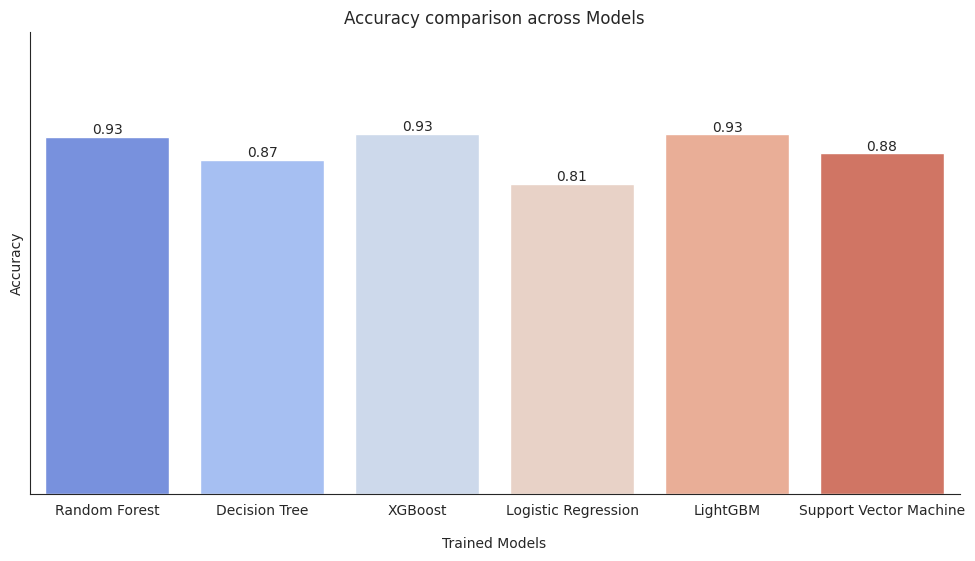

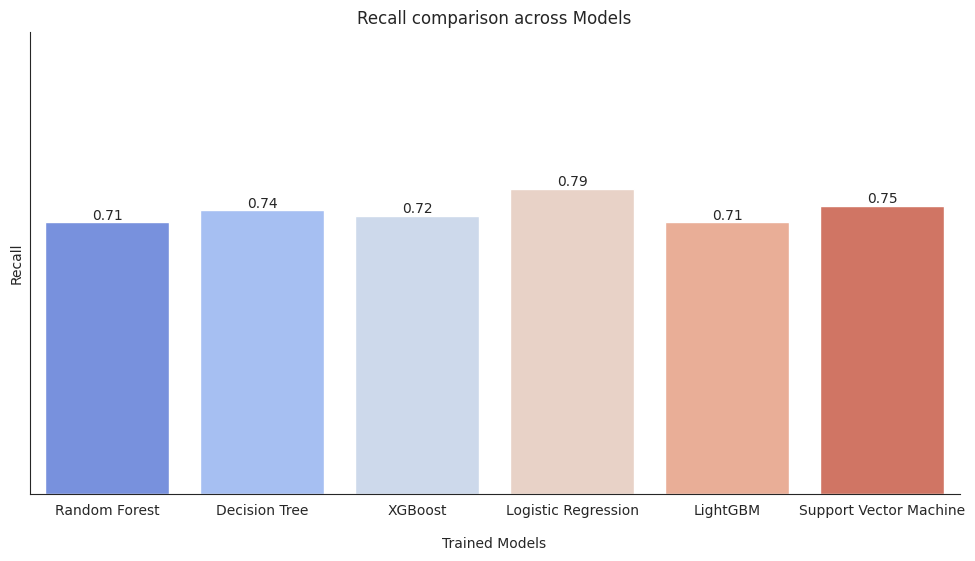

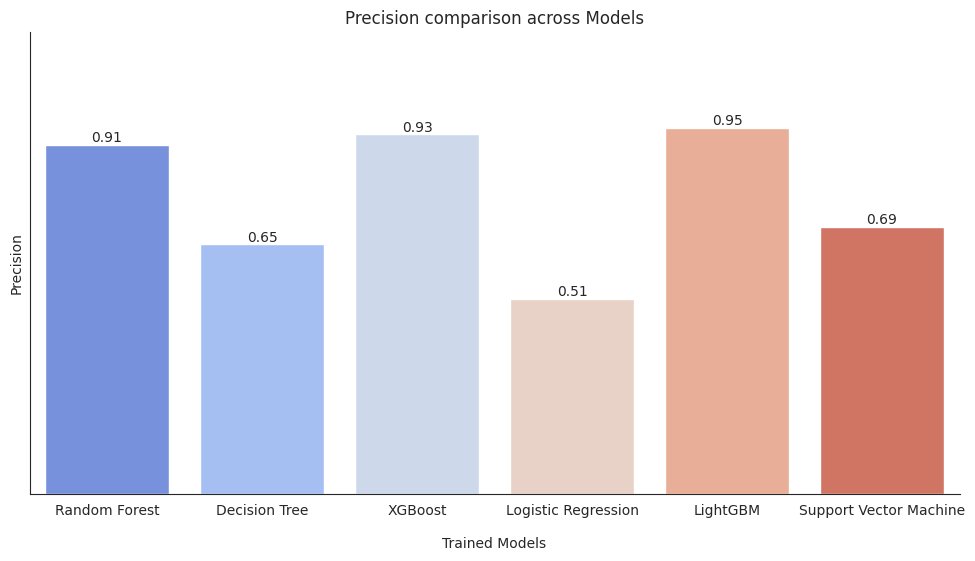

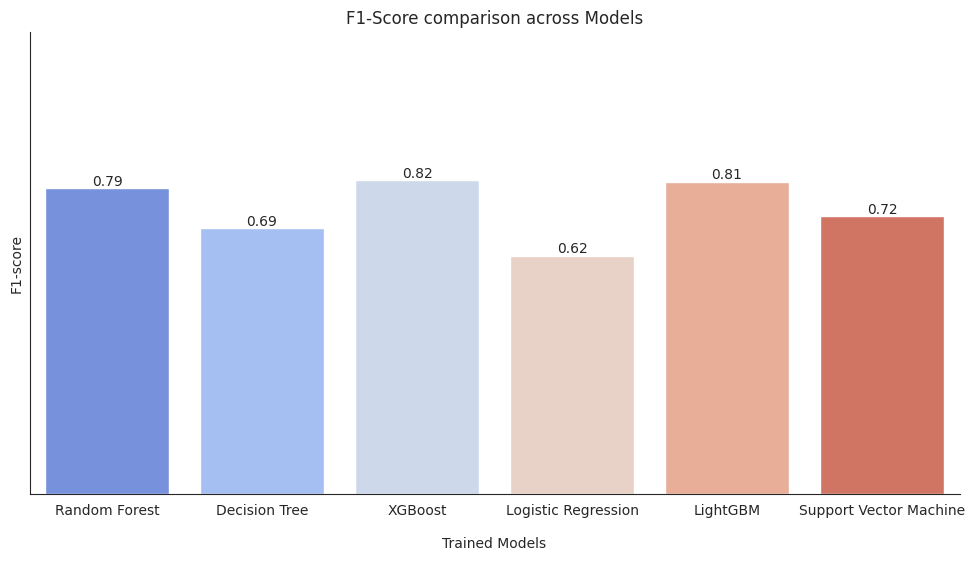

In [46]:
""" Visualize model metrics """

# Store results in dataframe
model_results = pd.DataFrame({
    'model': model_name,
    'Accuracy': model_accuracy,
    'Recall': model_recall,
    'Precision': model_precision,
    'F1-score': model_f1score
})

for col in model_results.columns:
  if col == 'model':
    continue;

  else:
    # Visualize metrics
    fig,ax = plt.subplots(figsize=(12,6))
    sns.barplot(data=model_results, x='model', y=f'{col}',palette='coolwarm')

    for container in ax.containers:
      ax.bar_label(container, fmt='%.2f', label_type='edge')

    plt.ylim(0, 1.2)
    plt.yticks([])
    plt.title(f'{col.title()} comparison across Models')
    plt.savefig(f'{col.title()} comparison across Models before tuning', dpi=300)
    sns.despine(top=True, right=True)
    plt.grid(axis='y',linestyle='--', alpha=0.5)
    plt.xlabel('Trained Models',labelpad=14)
    plt.show()

  print('\n\n')

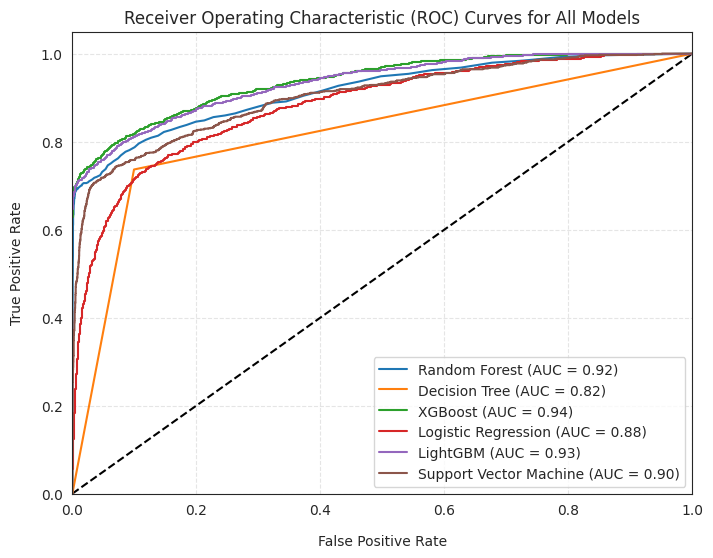

In [47]:
# Plot roc_curve for all models for comparison
plt.figure(figsize=(8, 6), dpi=100)
plt.plot([0, 1], [0, 1],  color='black', linestyle='--')

# plot each model result by looping through result dictionary
for result in roc_results.values():
  fpr,tpr = result['fpr'],result['tpr']
  roc_auc_result = result['roc_auc']
  plt.plot(fpr, tpr, label=f'{result['name']} (AUC = {roc_auc_result:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', labelpad=12)
plt.ylabel('True Positive Rate', labelpad=12)
plt.title('Receiver Operating Characteristic (ROC) Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True,linestyle='--', alpha=0.5)
plt.savefig('Receiver Operating Characteristic (ROC) Curves for All Models before tunning.png', dpi=300)
plt.show()

# **Hyper-Parameter Tuning**

In [48]:
""" Multiple dictionaries to store models with parameters for hyperparameters and model receiver operating characteristics result"""

# Create dictionary to store models
hyp_models = {
  'rfc': {
    'name':'Random Forest',
    'model': RandomForestClassifier(random_state=42),
    'params':{
      'model__n_estimators': [200, 300, 500, 700],
      'model__max_depth': [10, 15, 20, 30, 50, None],
      'model__min_samples_split': [2, 5, 10],
      'model__min_samples_leaf': [1, 2, 4],
      'model__max_features': ['sqrt', 'log2', None]
    }
  },
  'dtc': {
    'name': 'Decision Tree',
    'model': DecisionTreeClassifier(random_state=42),
    'params':{
      'model__criterion': ['gini','entropy'],
      'model__max_depth': [10, 20, 30, None],
      'model__min_samples_split': [4, 6, 8, 10],
      'model__min_samples_leaf': [1, 2, 4],
      'model__max_features': ['sqrt', 'log2', None]
    }
  },
  'xgb': {
    'name': 'XGBoost',
    'model': XGBClassifier(random_state=42),
    'params':{
      'model__n_estimators': [200, 500, 800, 1000],
      'model__max_depth': [3, 4, 5, 6, 8],
      'model__gamma': [0, 0.1, 0.2],
      'model__learning_rate': [0.01, 0.05],
      'model__colsample_bytree':[0.7,0.8,0.9,1.0],
      'model__min_child_weight': [1, 5, 10],
      'model__subsample': [0.7, 0.8, 0.9]
    }
  },
  'lgrc': {
    'name': 'Logistic Regression',
    'model': LogisticRegression(random_state=42, max_iter=1000),
    'params':{
      'model__penalty': ['l2', 'elasticnet'],
      'model__C': [0.1, 1, 10, 50],
      'model__solver': ['saga'],
      'model__l1_ratio': [0, 0.5, 0.7, 1]
    }
  },
  'lgbm': {
    'name': 'LightGBM',
    'model': LGBMClassifier(random_state=42, verbosity=-1,),
    'params':{
      'model__num_leaves': [15, 31, 63],
      'model__min_child_samples': [20, 50, 100],
      'model__max_depth': [-1, 5, 8, 12],
      'model__learning_rate': [0.01, 0.05],
      'model__n_estimators': [400, 700, 1000, 2000],
      'model__feature_fraction':[0.7,0.8,0.9,1.0]
    }
  },
  'svm': {
    'name': 'Support Vector Machine',
    'model': SVC(probability=True, random_state=42),
    'params':{
      'model__C': [1, 10, 50],
      'model__kernel': ['rbf'],
      'model__gamma': ['scale', 0.1]
    }
  }
}

# Dictionary to store receiver operating characteristics results
hp_roc_results = {}

In [49]:
# Create dictionary and list to store recall, accuracy score, precision and f1-score of each tunned model for visualization

hyp_model_name = []
hyp_model_accuracy = []
hyp_model_precision = []
hyp_model_recall = []
hyp_model_f1score = []

----------------------------------------------------------------------------------------------------
--> Random Forest <--
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      4295
           1       0.90      0.71      0.79      1067

    accuracy                           0.93      5362
   macro avg       0.92      0.85      0.88      5362
weighted avg       0.93      0.93      0.92      5362

----------------------------------------------------------------------------------------------------
--> Best paramter found for Random Forest --
RandomForestClassifier(max_depth=15, max_features=None, min_samples_leaf=4,
                       min_samples_split=5, n_estimators=300, random_state=42)





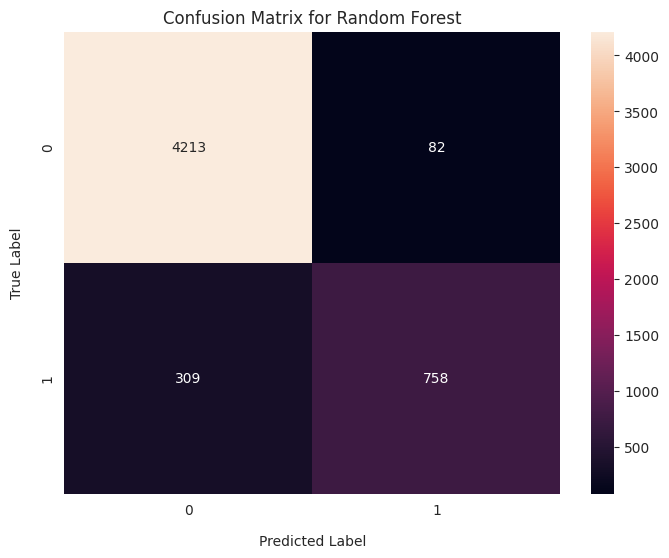

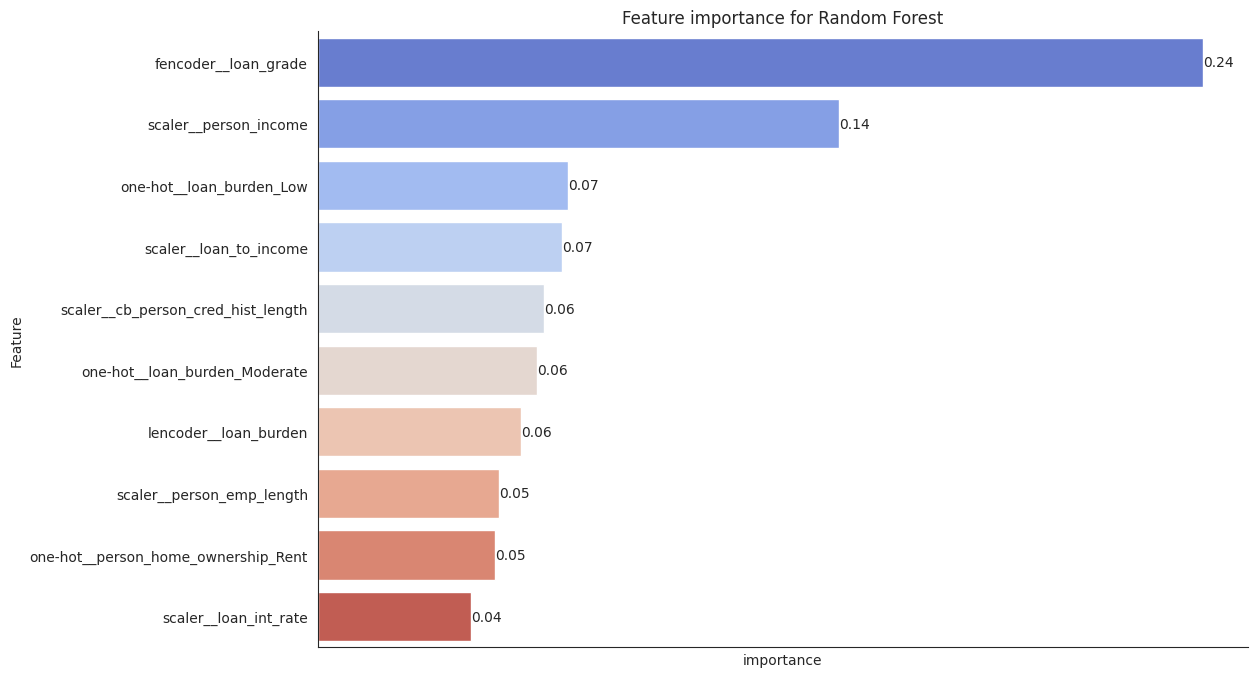



----------------------------------------------------------------------------------------------------
Predictions on test data by Random Forest
----------------------------------------------------------------------------------------------------
    True Label  Predcited Label Correct Predicition
5            0                0                 Yes
21           0                0                 Yes
3            1                0                  No
26           1                1                 Yes
10           1                0                  No
19           0                0                 Yes
14           0                0                 Yes
20           0                0                 Yes
13           0                0                 Yes
4            0                0                 Yes




----------------------------------------------------------------------------------------------------
--> Decision Tree <--
-------------------------------------------------------

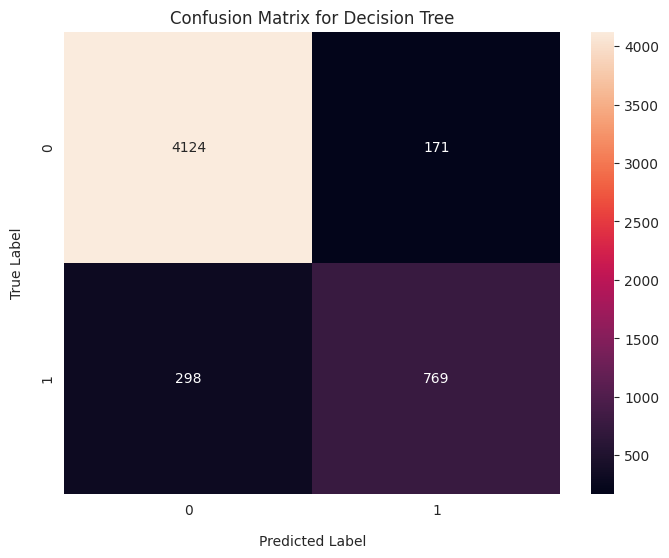

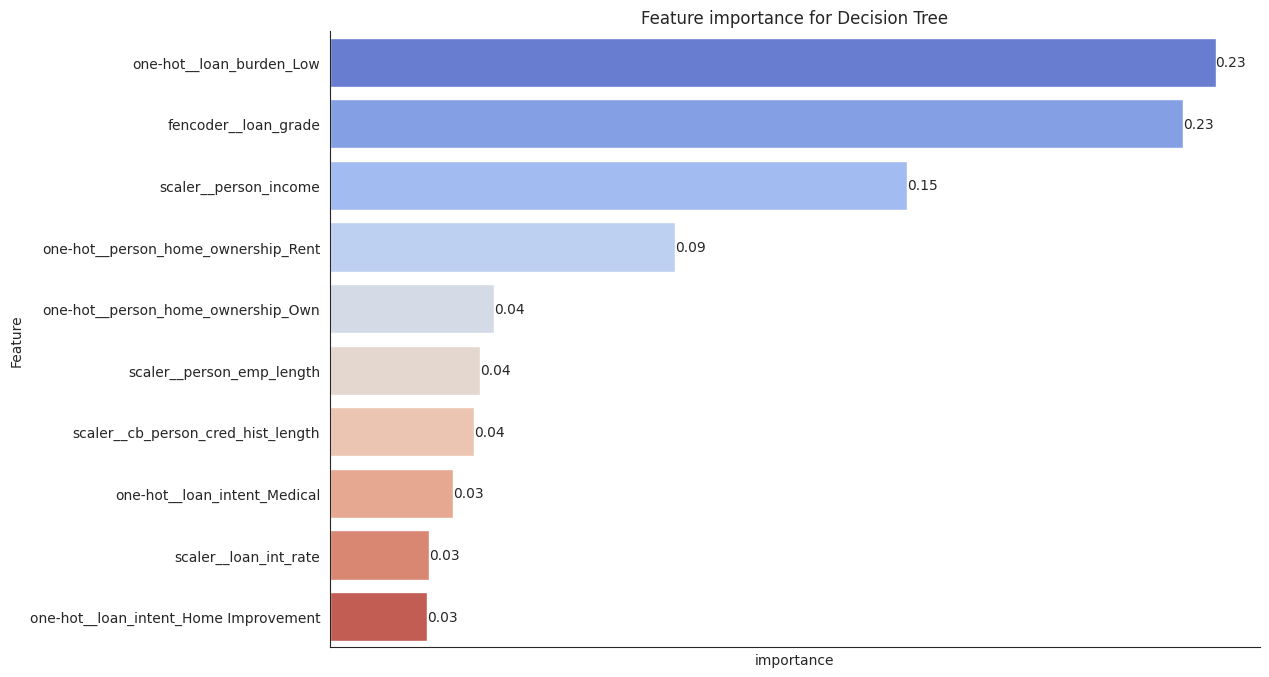



----------------------------------------------------------------------------------------------------
Predictions on test data by Decision Tree
----------------------------------------------------------------------------------------------------
    True Label  Predcited Label Correct Predicition
0            1                1                 Yes
23           1                0                  No
17           0                0                 Yes
16           0                0                 Yes
20           0                0                 Yes
22           1                0                  No
5            0                0                 Yes
24           0                0                 Yes
11           0                0                 Yes
4            0                1                  No




----------------------------------------------------------------------------------------------------
--> XGBoost <--
-------------------------------------------------------------

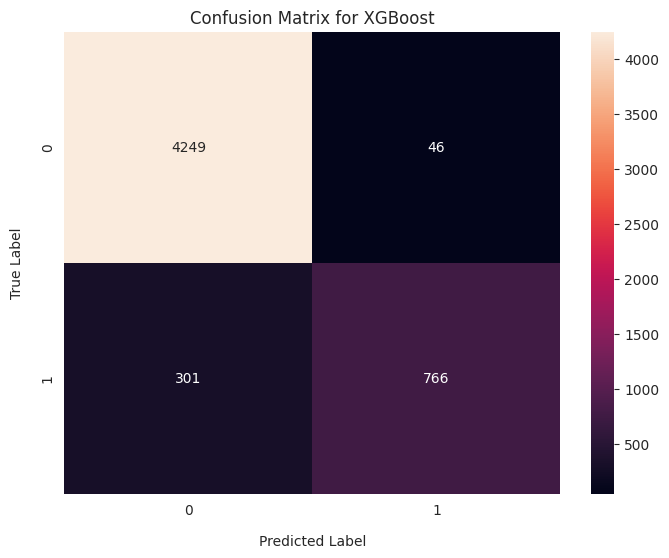

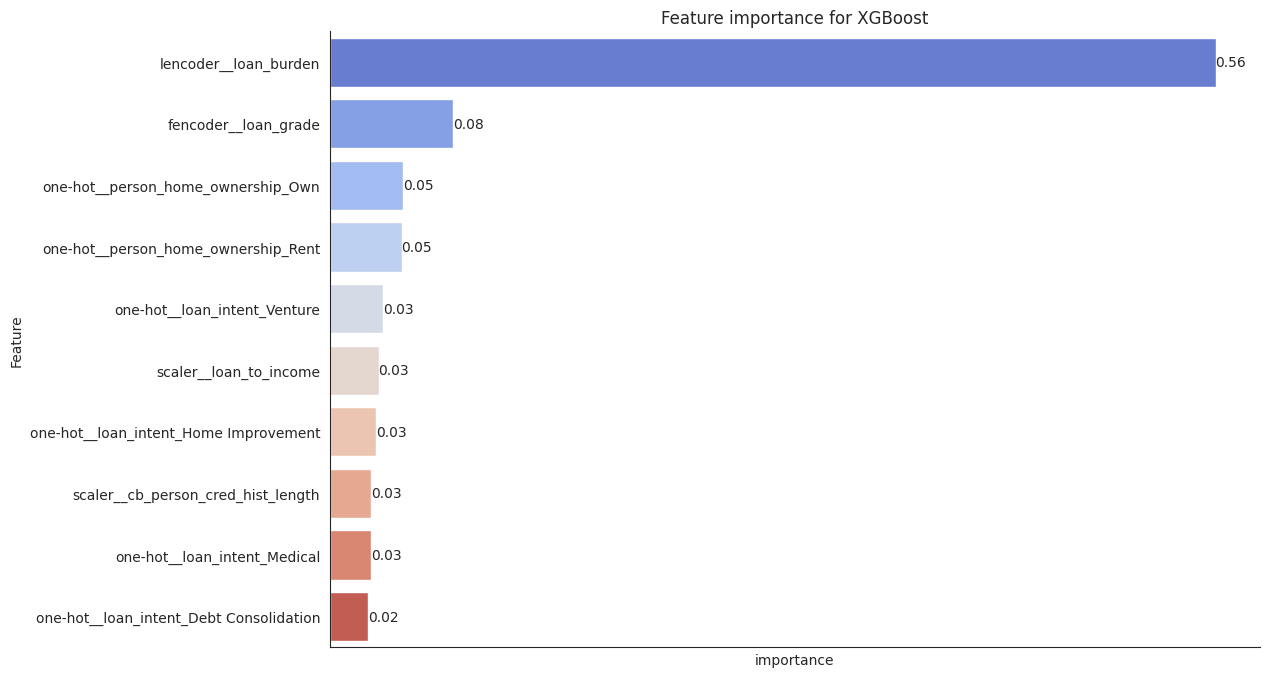



----------------------------------------------------------------------------------------------------
Predictions on test data by XGBoost
----------------------------------------------------------------------------------------------------
    True Label  Predcited Label Correct Predicition
26           1                1                 Yes
4            0                0                 Yes
18           0                0                 Yes
19           0                0                 Yes
20           0                0                 Yes
6            0                0                 Yes
8            1                1                 Yes
0            1                1                 Yes
15           1                1                 Yes
22           1                0                  No




----------------------------------------------------------------------------------------------------
--> Logistic Regression <--
-------------------------------------------------------

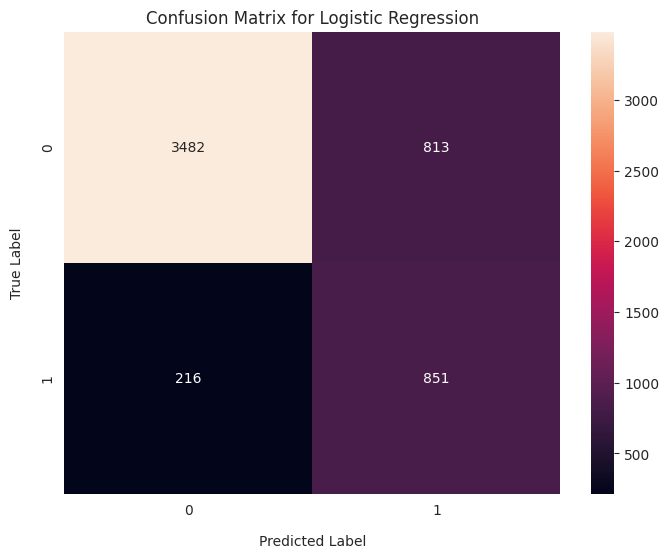

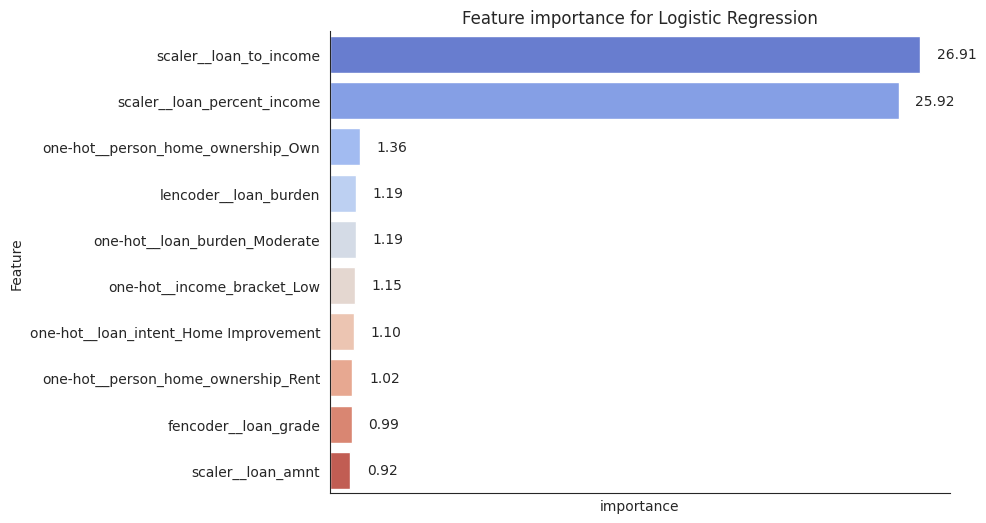



----------------------------------------------------------------------------------------------------
Predictions on test data by Logistic Regression
----------------------------------------------------------------------------------------------------
    True Label  Predcited Label Correct Predicition
8            1                1                 Yes
25           1                1                 Yes
4            0                1                  No
7            0                0                 Yes
19           0                1                  No
13           0                0                 Yes
18           0                0                 Yes
16           0                0                 Yes
3            1                0                  No
14           0                0                 Yes




----------------------------------------------------------------------------------------------------
--> LightGBM <--
------------------------------------------------------

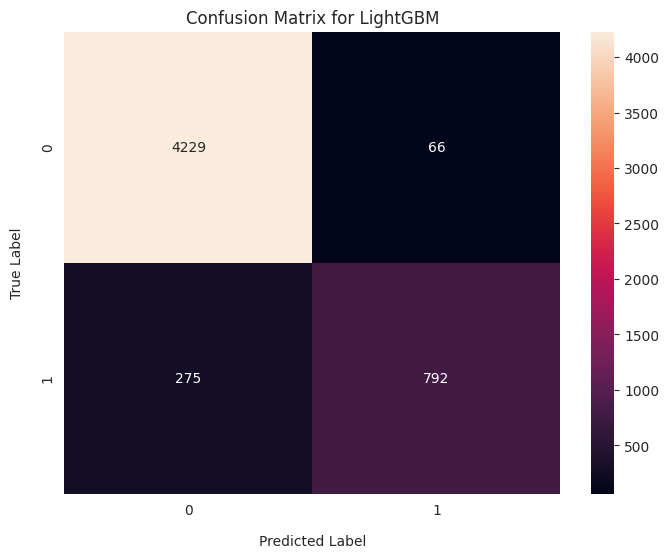

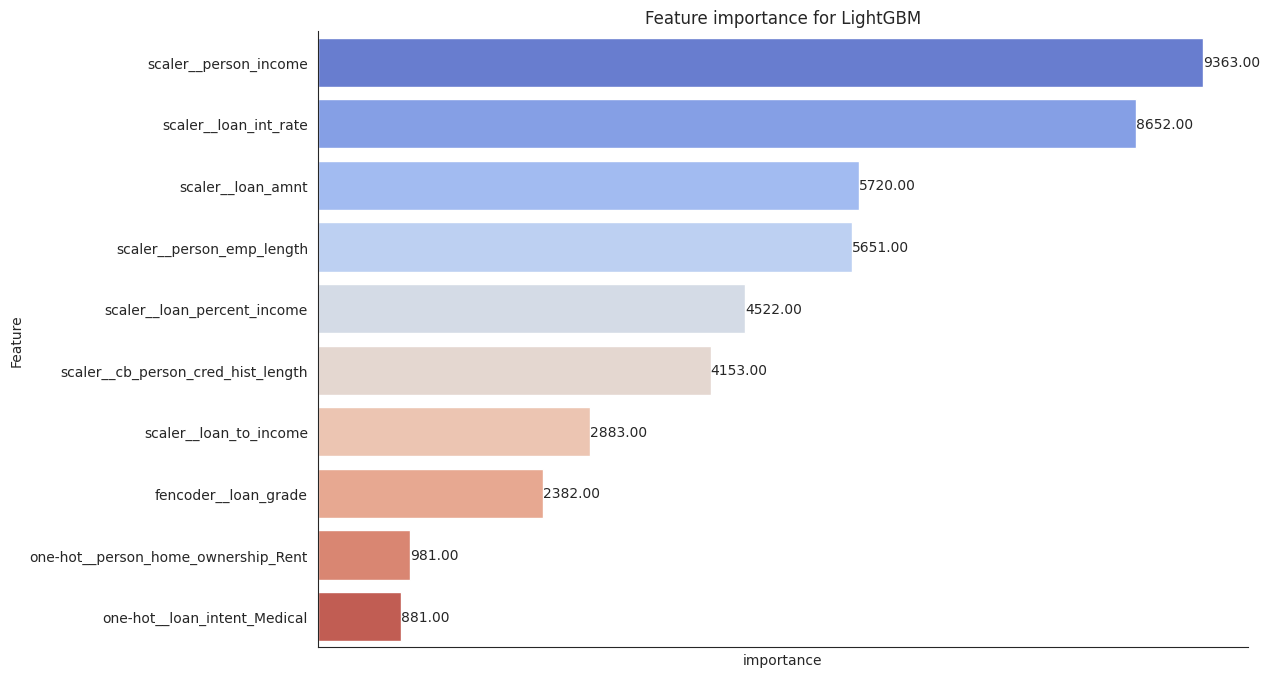



----------------------------------------------------------------------------------------------------
Predictions on test data by LightGBM
----------------------------------------------------------------------------------------------------
    True Label  Predcited Label Correct Predicition
16           0                0                 Yes
26           1                1                 Yes
0            1                1                 Yes
19           0                0                 Yes
9            0                0                 Yes
2            0                0                 Yes
1            0                0                 Yes
20           0                0                 Yes
15           1                1                 Yes
23           1                0                  No




----------------------------------------------------------------------------------------------------
--> Support Vector Machine <--
---------------------------------------------------

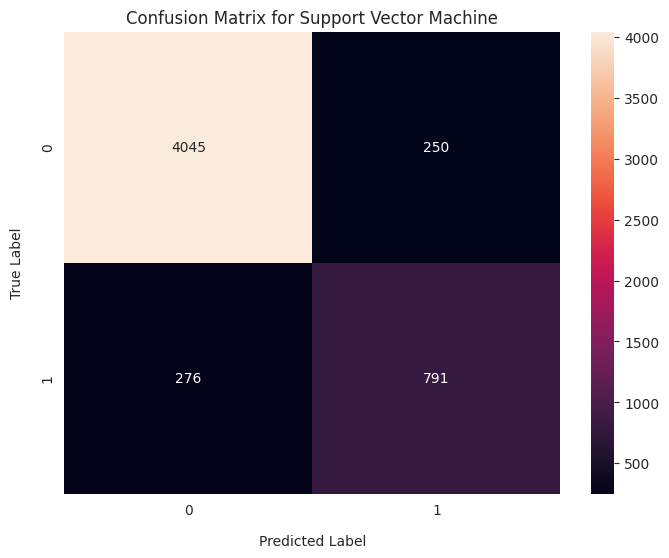




Direct feature importance is not available for Support Vector Machine
----------------------------------------------------------------------------------------------------
Predictions on test data by Support Vector Machine
----------------------------------------------------------------------------------------------------
    True Label  Predcited Label Correct Predicition
16           0                0                 Yes
0            1                1                 Yes
9            0                0                 Yes
14           0                0                 Yes
24           0                0                 Yes
5            0                0                 Yes
22           1                0                  No
6            0                0                 Yes
8            1                1                 Yes
1            0                0                 Yes






In [50]:
''' Training models by looping through the hyperparameter model dictionary while also outputing metrics'''

for abbr, model_dict in hyp_models.items():

  # Change the default model in the pipeline to the current running model
  pipeline.set_params(model = model_dict['model'])

  # Use the randomizedsearch CV to find the best model and perform the prediction
  model_search = RandomizedSearchCV(pipeline, model_dict['params'], n_iter=50,cv=5, scoring='f1', n_jobs=-1, random_state=42)

  # Fit data for training
  model_search.fit(X_Main_train,Y_Main_train)

  # Find the best estimator from the randomizedsearchcv
  best_search = model_search.best_estimator_

  # Make prediction using
  y_pred = best_search.predict(x_valid)

  # Get metrics
  class_report = classification_report(y_valid,y_pred)
  cm = confusion_matrix(y_valid,y_pred)

  #-----------------------------------------------------------------

   # Store result of each model metrics for visualization
  hyp_model_name.append(model_dict['name'])
  hyp_model_accuracy.append(accuracy_score(y_valid,y_pred))
  hyp_model_recall.append(recall_score(y_valid,y_pred))
  hyp_model_precision.append(precision_score(y_valid,y_pred))
  hyp_model_f1score.append(f1_score(y_valid,y_pred))

  #-----------------------------------------------------------------

  # Show metrics
  print('-'*100)
  print(f'--> {model_dict['name']} <--')
  #print('\n')

  #Print the best estimator
  # print(f'Best Estimator: {best_search}')

  print('-'*100)
  print(class_report)
  #-----------------------------------------------------------------

  # Print out the best parameter
  print('-'*100)
  print(f'--> Best paramter found for {model_dict['name']} --')
  print(best_search.named_steps['model'])

  # Add line break
  print('\n\n')


  #-----------------------------------------------------------------

  # Plot the confusion matrix of the model
  plt.subplots(figsize=(8,6), dpi=100)
  sns.heatmap(cm,annot=True,fmt='d',cbar=True,)
  plt.xlabel('Predicted Label', labelpad=12)
  plt.ylabel('True Label', labelpad=12)
  plt.title(f'Confusion Matrix for {model_dict['name']}')
  plt.savefig(f'Confusion Matrix for {model_dict['name']} after tunning.png', dpi=300)
  plt.show()

  # Add line break
  print('\n\n')

  #-----------------------------------------------------------------

  # Print the feature importance
  if abbr == 'lgrc':

    # flattened 2D array returned by coef_ and took absolute value to match with feature importance dimension and round to 2 decimal point
    importance = np.round(np.abs(best_search.named_steps['model'].coef_.flatten()),2)

    # Get feature names after preprocessing
    feature_names = best_search.named_steps['preprocessor'].get_feature_names_out()
    # Create dataframe to output columns and importance as a dataframe
    df_importance = pd.DataFrame({
        'columns': feature_names,
        'importance': importance
    })

    # Visualize top 10 feature importance
    df_importance = df_importance.sort_values(by='importance', ascending=False).head(10)

    fig,ax = plt.subplots(figsize=(8,6),dpi=100)
    sns.barplot(data = df_importance, x='importance', y='columns', palette='coolwarm')

    for container in ax.containers:
      plt.bar_label(container, fmt='%.2f', padding=12)

    plt.title(f'Feature importance for {model_dict['name']}')
    plt.xticks(rotation=45)
    plt.ylabel('Feature')
    sns.despine(top=True, right=True)
    plt.grid(axis='x',linestyle='--', alpha=0.5)
    plt.xticks([])
    plt.show()
    print('\n')

    # Print out the important features
    df_importance.head()

  elif abbr == 'svm':

    print(f'Direct feature importance is not available for {model_dict['name']}')

  else:

    importance = best_search.named_steps['model'].feature_importances_
    # Get feature names after preprocessing
    feature_names = best_search.named_steps['preprocessor'].get_feature_names_out()
    # Create dataframe to output columns and importance as a dataframe
    df_importance = pd.DataFrame({
        'columns': feature_names,
        'importance': importance
    })


    #-----------------------------------------------------------------

    # Visualize top 10 feature importanc eof model
    df_importance = df_importance.sort_values(by='importance', ascending=False).head(10)

    fig,ax = plt.subplots(figsize=(12,8),dpi=100)
    sns.barplot(data = df_importance, x='importance', y='columns', palette='coolwarm')

    for container in ax.containers:
      ax.bar_label(container, fmt='%.2f', label_type='edge')

    plt.title(f'Feature importance for {model_dict['name']}')
    plt.xticks(rotation=90)
    plt.ylabel('Feature')
    sns.despine(top=True, right=True)
    plt.grid(axis='x',linestyle='--', alpha=0.5)
    plt.xticks([])
    plt.show()

    print('\n')

    # Print out the important features
    df_importance.head()

  #-----------------------------------------------------------------

  """ Make predictions with each model on the test data """
  print('-'*100)
  print(f'Predictions on test data by {model_dict['name']}')
  print('-'*100)

  # Predict on unseen data from x_test
  y_test_pred = best_search.predict(x_test)

  # Map predictions if they are equal
  correct_predicition = [ 'Yes' if y_test_pred[i] == y_test.iloc[i] else 'No' for i in range(len(y_test_pred)) ]

  # Dataframe to hold
  predicted = pd.DataFrame({
      'True Label' : y_test.values,
      'Predcited Label' : y_test_pred,
      'Correct Predicition' : correct_predicition
  })

  print(predicted.sample(10))

  # Add line break
  print('\n\n\n')

  #-----------------------------------------------------------------

  # Empty dictionary for inner storage of each model result
  hp_roc_results[abbr] = {}

  # Store data into each mdoel dictionaty
  hp_roc_results[abbr]['name'] = model_dict['name']
  hp_roc_results[abbr]['y_proba'] = best_search.predict_proba(x_valid)[:, 1]
  hp_roc_results[abbr]['fpr'],hp_roc_results[abbr]['tpr'],hp_roc_results[abbr]['thresholds'] = roc_curve(y_valid, hp_roc_results[abbr]['y_proba'])
  hp_roc_results[abbr]['roc_auc'] = roc_auc_score(y_valid, hp_roc_results[abbr]['y_proba'])

  #-----------------------------------------------------------------


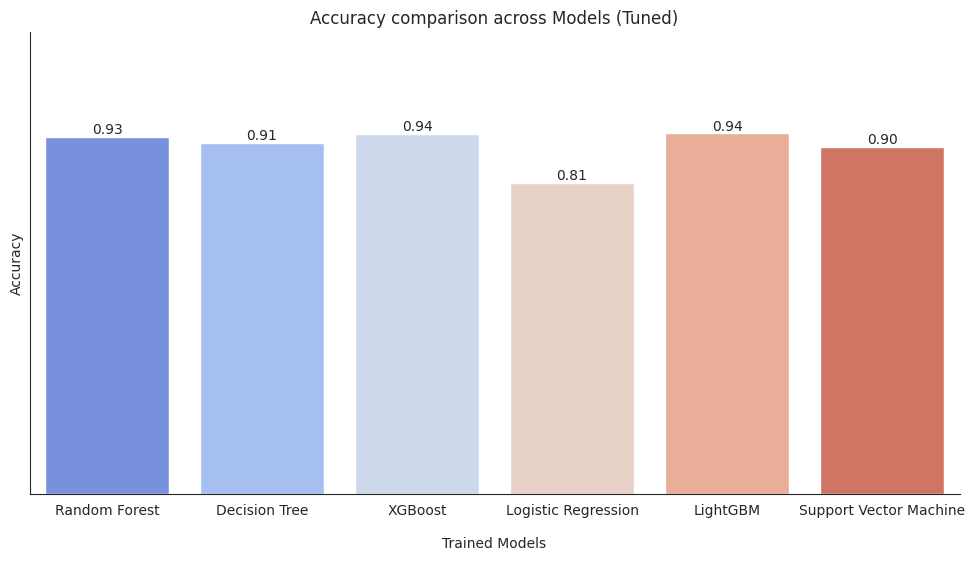

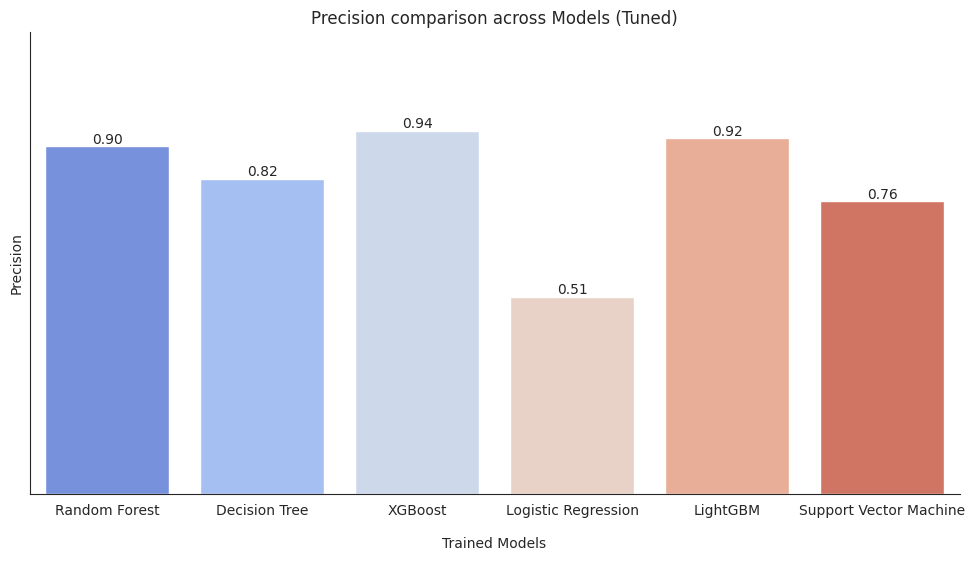

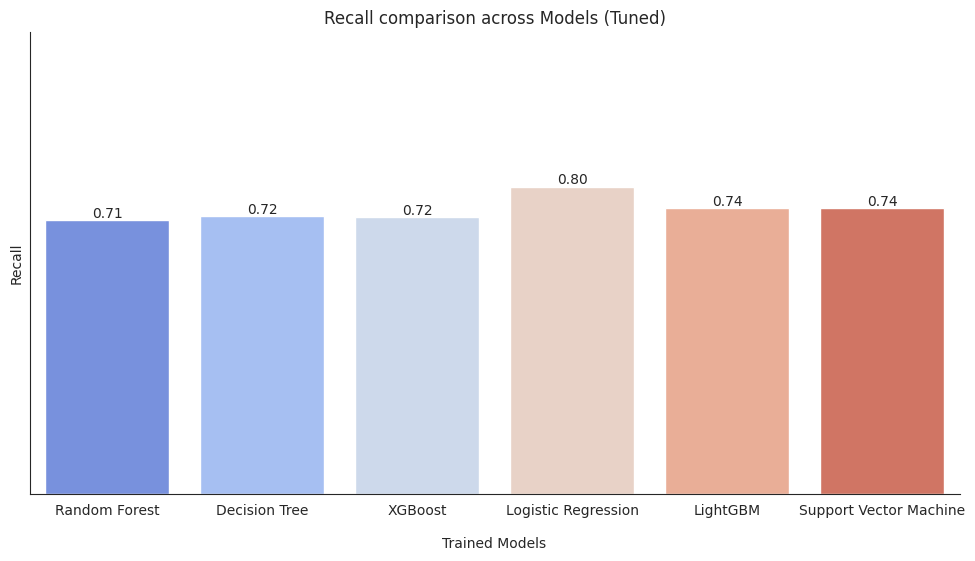

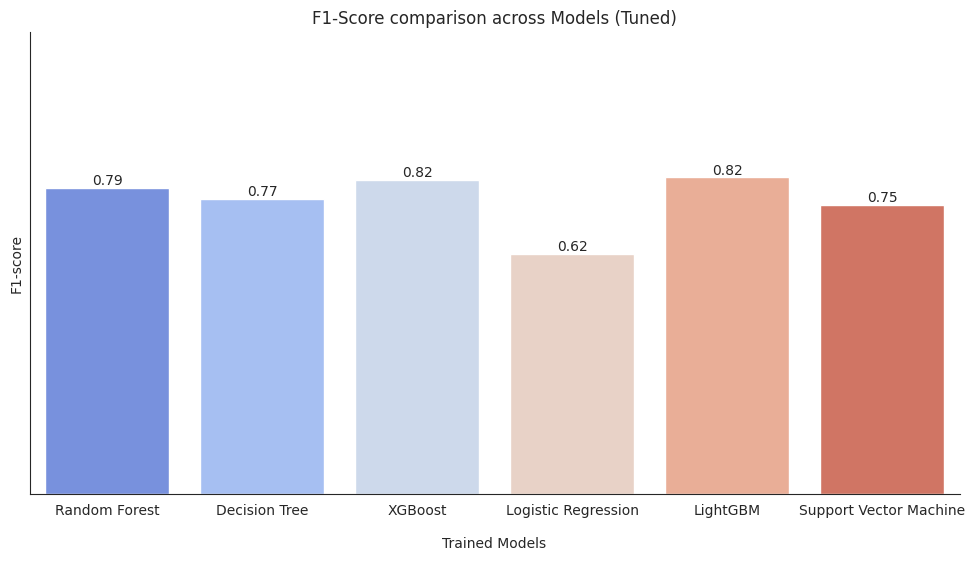

In [51]:
""" Visualize model metrics """

# Store results in dataframe
hyp_model_results = pd.DataFrame({
    'model': hyp_model_name,
    'Accuracy': hyp_model_accuracy,
    'Precision': hyp_model_precision,
    'Recall': hyp_model_recall,
    'F1-score': hyp_model_f1score
})

for col in hyp_model_results.columns:
  if col == 'model':
    continue;

  else:
    # Visualize metrics
    fig,ax = plt.subplots(figsize=(12,6))
    sns.barplot(data=hyp_model_results, x='model', y=f'{col}',palette='coolwarm')

    for container in ax.containers:
      ax.bar_label(container, fmt='%.2f', label_type='edge')

    plt.ylim(0, 1.2)
    plt.yticks([])
    plt.title(f'{col.title()} comparison across Models (Tuned)')
    plt.savefig(f'{col.title()} comparison across Models after tuning', dpi=300)
    # plt.ylabel('Score', labelpad=14)
    sns.despine(top=True, right=True)
    plt.grid(axis='y',linestyle='--', alpha=0.5)
    plt.xlabel('Trained Models',labelpad=14)
    plt.show()

  print('\n\n')

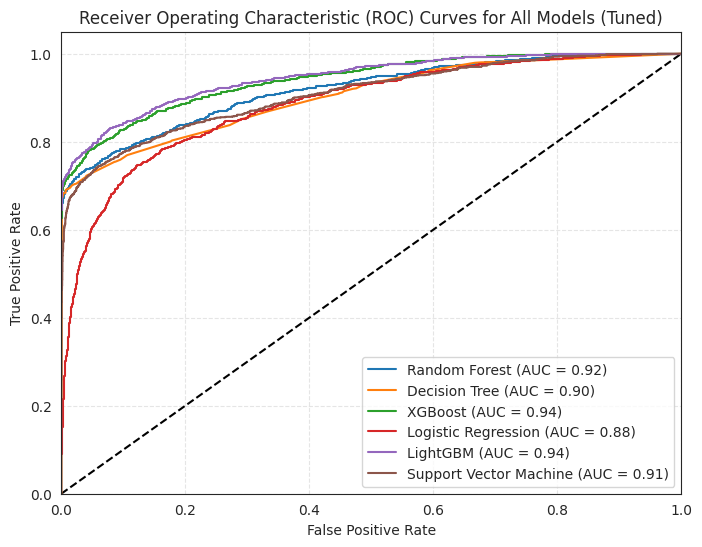

In [52]:
# Plot roc_curve for all models for comparison
plt.figure(figsize=(8, 6), dpi=100)
plt.plot([0, 1], [0, 1],  color='black', linestyle='--')

# plot each model result by looping through result dictionary
for result in hp_roc_results.values():
  fpr,tpr = result['fpr'],result['tpr']
  hp_roc_auc_result = result['roc_auc']
  plt.plot(fpr, tpr, label=f'{result['name']} (AUC = {hp_roc_auc_result:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for All Models (Tuned)')
plt.legend(loc='lower right')
plt.grid(True,linestyle='--', alpha=0.5)
plt.savefig('Receiver Operating Characteristics (ROC) Curves for All Models after tuning.png', dpi=300)
plt.show()